## Run KL analysis for intergenic region, footprinting region, and DHS sites

## There are functions to include

In [12]:
import logging
import os
import math

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.nn import PyroModule


import torch.distributions.transforms as transforms

from tqdm import tqdm
import matplotlib

In [13]:
## Model fitting
####################################################
def plot_losses(losses):
    """
    Make a plot of SVI losses
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(losses)
    ax.set_xlabel("SVI step")
    ax.set_ylabel("ELBO loss");
    ax.set_yscale("log")
    return fig, ax

## Useful transformations
####################################################
pad = torch.nn.ConstantPad1d((1,0), 0.)            # Add a 0 to a tensor
softmax = torch.nn.Softmax(-1)                     # softmax transform along the last dimension
relu = torch.nn.ReLU()                             # map everything < 0 -> 0 
order_trans = dist.transforms.OrderedTransform()   # y_0=x_0; y_i=y_0+sum_j=1^i exp(x_j) [not really used anymore, weird properties]
####################################################

## Transformations of the SFS
####################################################
def multinomial_trans(sfs_probs, offset=None):
    sfs_probs = np.array(sfs_probs)
    P_0 = sfs_probs[...,0]
    if offset:
        betas = np.log(sfs_probs[...,1:]) - np.log(P_0[...,None]) - offset
    else:
        betas = np.log(sfs_probs[...,1:]) - np.log(P_0[...,None])
    return betas

def multinomial_trans_torch(sfs_probs):
    P_0 = sfs_probs[...,0]
    return torch.log(sfs_probs[...,1:]) - torch.log(P_0[...,None])

def KL_fw(neut_probs, sel_probs):
    return np.sum(neut_probs * (np.log(neut_probs) - np.log(sel_probs)), axis=-1)

def KL_rv(neut_probs, sel_probs):
    return np.sum(sel_probs * (np.log(sel_probs) - np.log(neut_probs)), axis=-1)


def calc_KL_genewise(fit, ref_mu_ii=None):
    """
    Calculate KL between the neutral distribution at a reference mutation rate and 
    the fit selected distribution at each gene.
    """
    neut_sfs_full = fit["neut_sfs_full"]
    beta_neut_full = fit["beta_neut_full"]
    mu_ref = fit["mu_ref"]
    if ref_mu_ii:
        fit["ref_mu_ii"] = ref_mu_ii
    ref_mu_ii = fit["ref_mu_ii"]
    beta_neut = beta_neut_full[ref_mu_ii,:] # neutral betas for the reference mutation rate

    beta_prior_b = fit["beta_prior_b"] # need the interaction term between mutation rate and selection
    post_samples = fit["post_samples"] # grab dictionary with posterior samples

    # apply the correction transormation to the latent beta_sel
    # (definitely the kind of thing to store elsewhere in the class structure)
    if fit["trans"] == "abs":
        post_trans = torch.cumsum(torch.abs(post_samples["beta_sel"]), dim=-1)
    elif fit["trans"] =="logabs":
        post_trans = torch.cumsum(torch.log(torch.abs(post_samples["beta_sel"])+1), dim=-1)
    elif fit["trans"]=="relu":
        post_trans = torch.cumsum(relu(post_samples["beta_sel"]), dim=-1)
    elif fit["trans"]=="logrelu":
        post_trans = torch.cumsum(torch.log(relu(post_samples["beta_sel"])+1), dim=-1)
    
    # transform to probabilities (SFS) for ecah gene and store as a numpy array
    post_probs = softmax(pad(beta_neut - post_trans -
                              mu_ref[ref_mu_ii]*torch.cumsum(beta_prior_b, -1)*post_trans
                             )
                         ).detach().numpy()
    
    # calculate KL for each draw from the posterior distribution for each gene
    KL_fw_post = KL_fw(neut_sfs_full[ref_mu_ii,:].detach().numpy(), post_probs)
    KL_rv_post = KL_rv(neut_sfs_full[ref_mu_ii,:].detach().numpy(), post_probs)
    
    fit["post_probs"] = post_probs
    fit["KL_fw_post"] = KL_fw_post
    fit["KL_rv_post"] = KL_rv_post
    
    return fit

## Change Evan's Code to class format

In [14]:
class KL_inference():
    def __init__(self, neut_sfs_full, n_bins, mu_ref, n_covs, n_genes,
                 n_mix=2, cov_sigma_prior=torch.tensor(0.1, dtype=torch.float32), ref_mu_ii=-1,
                 trans="abs", pdist="t"):
        
        mu = torch.unique(mu_vals)             # set of all possible mutation rates
        n_mu = len(mu)                         # number of unique mutation rates
        
        beta_neut_full = multinomial_trans_torch(neut_sfs_full) #neut_sfs_full is the neutral sfs
        beta_neut = beta_neut_full[ref_mu_ii,:]
        self.beta_neut = beta_neut
        
        self.n_bins = n_bins        
        self.mu_ref = mu_ref
        self.n_covs = n_covs
        self.n_genes = n_genes
        
        self.n_mix = n_mix
        self.cov_sigma_prior = cov_sigma_prior
        self.trans = trans
        self.pdist = pdist
        
    def model(self, mu_vals, gene_ids, covariates = None, sample_sfs=None):
        n_sites = len(mu_vals)
        
        ## Setup flexible prior
        # parameters describing the prior over genes are set as pyro.param, meaning they will get point estimates (no posterior)
        if self.pdist=="t":
            # t-distribution can modulate covariance (L) and kurtosis (df)
            # uses a fixed "point mass" at zero as one of the mixtures, not sure if this should be kept
            beta_prior_mean = pyro.param("beta_prior_mean", torch.randn((self.n_mix-1,self.n_bins)),
                                         constraint=constraints.real)
            beta_prior_L = pyro.param("beta_prior_L", torch.linalg.cholesky(0.01*torch.diag(torch.ones(self.n_bins, dtype=torch.float32))).expand(self.n_mix-1, self.n_bins, self.n_bins), 
                                                                            constraint=constraints.lower_cholesky)
            beta_prior_df = pyro.param("beta_prior_df", torch.tensor([10]*(self.n_mix-1), dtype=torch.float32), constraint=constraints.positive)
            mix_probs = pyro.param("mix_probs", torch.ones(self.n_mix, dtype=torch.float32)/self.n_mix, constraint=constraints.simplex)
        elif self.pdist=="normal":
            # normal model has zero covariance, a different variance for each bin though
            mix_probs = pyro.param("mix_probs", torch.ones(self.n_mix, dtype=torch.float32)/self.n_mix, constraint=constraints.simplex)
            beta_prior_loc = pyro.param("beta_prior_loc", torch.randn((self.n_mix, self.n_bins)), constraint=constraints.real)
            beta_prior_scale = pyro.param("beta_prior_scale", torch.rand((self.n_mix, self.n_bins)), constraint=constraints.positive)

        # interaction term bewteen gene-based selection and mutation rate
        beta_prior_b = pyro.param("beta_prior_b", torch.tensor([0.001]*self.n_bins, dtype=torch.float32), constraint=constraints.positive)
        
        if self.n_covs > 0:
            # Each covariate has a vector of betas, one for each bin, maybe think about different prior here?
            with pyro.plate("covariates", self.n_covs):
                beta_cov = pyro.sample("beta_cov", dist.HalfCauchy(self.cov_sigma_prior).expand([self.n_bins]).to_event(1))

        with pyro.plate("genes", self.n_genes):
            # sample latent betas from either t or normal distribution
            if self.pdist=="t":
                beta_sel = pyro.sample("beta_sel", dist.MixtureSameFamily(dist.Categorical(mix_probs),
                                       dist.MultivariateStudentT(df=torch.cat((beta_prior_df, torch.tensor([1000], dtype=torch.float32))), 
                                                                 loc=torch.cat((beta_prior_mean, 
                                                                                torch.tensor([0]*self.n_bins, dtype=torch.float32).expand((1, self.n_bins)))), 
                                                                 scale_tril=torch.cat((beta_prior_L, 
                                                                                       torch.linalg.cholesky(torch.diag(1e-8*torch.ones(self.n_bins, dtype=torch.float32))).expand(1, self.n_bins, self.n_bins))))))
            elif self.pdist=="normal":
                beta_sel = pyro.sample("beta_sel", dist.MixtureSameFamily(dist.Categorical(mix_probs),
                                                                          dist.Normal(beta_prior_loc, beta_prior_scale).to_event(1)))
            # apply transform to latent betas
            if self.trans == "abs":
                beta_trans = torch.cumsum(torch.abs(beta_sel), dim=-1)
            elif self.trans=="logabs":
                beta_trans = torch.cumsum(torch.log(torch.abs(beta_sel)+1), dim=-1)
            elif self.trans=="relu":
                beta_trans = torch.cumsum(relu(beta_sel), dim=-1)
            elif self.trans=="logrelu":
                beta_trans = torch.cumsum(torch.log(relu(beta_sel)+1), dim=-1)

        # calculate the multinomial coefficients for each gene and each mutation rate
        mu_adj = self.mu_ref[...,None] * torch.cumsum(beta_prior_b, -1) * beta_trans[...,None,:]
        mn_sfs = (self.beta_neut  - 
                  beta_trans[...,None,:] -
                  mu_adj)
        # convert to probabilities per-site and adjust for covariates
        if self.n_covs > 0:
            sfs = softmax(pad(mn_sfs[..., gene_ids, mu_vals, :] - torch.matmul(covariates, torch.cumsum(beta_cov, -1))))
        else:
            sfs = softmax(pad(mn_sfs[..., gene_ids, mu_vals, :]))

        with pyro.plate("sites", n_sites):
            pyro.sample("obs", dist.Categorical(sfs), obs=sample_sfs)
        

## load file

In [15]:
KL_data_dir = "/home/djl34/lab_pd/kl/data/"
scratch_dir = "/n/scratch3/users/d/djl34/"

In [16]:
sfs = pd.read_csv(KL_data_dir + "neutral_SFS_5bins.tsv", sep = "\t")

bin_columns = []

for i in range(5):
    bin_columns.append(str(i) + "_bin")

neutral_sfs = torch.tensor(sfs[bin_columns].values)

mu_ref = torch.tensor(sfs["mu"].values)

In [17]:
df = pd.read_csv(scratch_dir + "KL_input/intergenic_footprinting/22.tsv", sep = "\t")

In [18]:
# initially, filter out mu values that are not in the list
df = df[df["mu"].isin(list(sfs["mu"].unique()))]
res = dict(zip(sfs["mu"], sfs.index))
df["mu_index"] = [res[x] for x in df["mu"]]

In [19]:
mu_vals = torch.tensor(df["mu_index"].values)
gene_ids = torch.tensor(df["type"].values - 1)
sample_sfs = torch.tensor(df["Freq_bin"].values)

In [20]:
covariates = torch.tensor([1]*len(mu_vals))
covariates = covariates.unsqueeze(0).transpose(0,1).type(torch.FloatTensor)

## inference portion

In [21]:
#define variables
#define neut_sfs_full, mu_vals, gene_ids, covariates
n_covs = covariates.shape[-1]          # number of covariates included
n_genes = len(torch.unique(gene_ids))  # number of genes

n_covs = 0

# n_covs = 1
# n_genes = 3
n_bins = len(neutral_sfs[1]) - 1

In [22]:
#define model and guide
KL = KL_inference(neutral_sfs, n_bins, mu_ref, n_covs, n_genes)
model = KL.model
guide = pyro.infer.autoguide.AutoNormal(model)

In [23]:
#run inference
pyro.clear_param_store()
# run SVI
adam = pyro.optim.Adam({"lr":0.005})
elbo = pyro.infer.Trace_ELBO(num_particles=1, vectorize_particles=True)
svi = pyro.infer.SVI(model, guide, adam, elbo)
losses = []

In [24]:
n_steps = 1000

for step in tqdm(range(n_steps)): # tqdm is just a progress bar thing 
    loss = svi.step(mu_vals, gene_ids, covariates, sample_sfs)
    print(loss)
    losses.append(loss)

  0%|                                                                                                                      | 1/1000 [00:05<1:23:55,  5.04s/it]

13434074.15145797


  0%|▏                                                                                                                     | 2/1000 [00:07<1:00:29,  3.64s/it]

13285368.425146421


  0%|▎                                                                                                                       | 3/1000 [00:10<53:00,  3.19s/it]

13406748.377352409


  0%|▍                                                                                                                       | 4/1000 [00:13<49:53,  3.01s/it]

13158231.993677247


  0%|▌                                                                                                                       | 5/1000 [00:15<47:44,  2.88s/it]

13596936.265049882


  1%|▋                                                                                                                       | 6/1000 [00:18<46:06,  2.78s/it]

13493925.63240806


  1%|▊                                                                                                                       | 7/1000 [00:20<45:24,  2.74s/it]

13245028.365500264


  1%|▉                                                                                                                       | 8/1000 [00:23<45:07,  2.73s/it]

13307957.113720722


  1%|█                                                                                                                       | 9/1000 [00:26<44:21,  2.69s/it]

13184364.662898013


  1%|█▏                                                                                                                     | 10/1000 [00:28<44:03,  2.67s/it]

13577978.402335439


  1%|█▎                                                                                                                     | 11/1000 [00:31<44:03,  2.67s/it]

13519266.382842641


  1%|█▍                                                                                                                     | 12/1000 [00:34<43:45,  2.66s/it]

13346754.703051716


  1%|█▌                                                                                                                     | 13/1000 [00:36<43:44,  2.66s/it]

13279255.949073032


  1%|█▋                                                                                                                     | 14/1000 [00:39<43:36,  2.65s/it]

13507988.307525925


  2%|█▊                                                                                                                     | 15/1000 [00:42<43:27,  2.65s/it]

13249315.590130154


  2%|█▉                                                                                                                     | 16/1000 [00:44<43:21,  2.64s/it]

13378760.5991502


  2%|██                                                                                                                     | 17/1000 [00:47<43:24,  2.65s/it]

13345937.366274625


  2%|██▏                                                                                                                    | 18/1000 [00:50<43:21,  2.65s/it]

13463725.757401356


  2%|██▎                                                                                                                    | 19/1000 [00:52<43:30,  2.66s/it]

13620300.095265277


  2%|██▍                                                                                                                    | 20/1000 [00:55<43:03,  2.64s/it]

13614138.264449485


  2%|██▍                                                                                                                    | 21/1000 [00:58<43:15,  2.65s/it]

13348961.512258552


  2%|██▌                                                                                                                    | 22/1000 [01:00<43:09,  2.65s/it]

13763245.93679886


  2%|██▋                                                                                                                    | 23/1000 [01:03<43:12,  2.65s/it]

13449693.893487532


  2%|██▊                                                                                                                    | 24/1000 [01:06<43:10,  2.65s/it]

13312691.782832399


  2%|██▉                                                                                                                    | 25/1000 [01:08<43:04,  2.65s/it]

13584894.876413584


  3%|███                                                                                                                    | 26/1000 [01:11<43:11,  2.66s/it]

13301158.502621591


  3%|███▏                                                                                                                   | 27/1000 [01:13<43:07,  2.66s/it]

13539324.748598915


  3%|███▎                                                                                                                   | 28/1000 [01:16<42:45,  2.64s/it]

13414845.8021857


  3%|███▍                                                                                                                   | 29/1000 [01:19<42:46,  2.64s/it]

13490102.751018131


  3%|███▌                                                                                                                   | 30/1000 [01:21<42:42,  2.64s/it]

13294480.630523901


  3%|███▋                                                                                                                   | 31/1000 [01:24<42:37,  2.64s/it]

13447027.081546988


  3%|███▊                                                                                                                   | 32/1000 [01:27<42:31,  2.64s/it]

13495416.434006955


  3%|███▉                                                                                                                   | 33/1000 [01:29<42:36,  2.64s/it]

13526808.086456718


  3%|████                                                                                                                   | 34/1000 [01:32<42:31,  2.64s/it]

13534447.807325166


  4%|████▏                                                                                                                  | 35/1000 [01:35<42:28,  2.64s/it]

13177346.868505292


  4%|████▎                                                                                                                  | 36/1000 [01:37<42:00,  2.61s/it]

13427452.250305943


  4%|████▍                                                                                                                  | 37/1000 [01:40<42:09,  2.63s/it]

13626467.942004552


  4%|████▌                                                                                                                  | 38/1000 [01:42<42:03,  2.62s/it]

13771574.21323739


  4%|████▋                                                                                                                  | 39/1000 [01:45<42:10,  2.63s/it]

13262775.264701445


  4%|████▊                                                                                                                  | 40/1000 [01:48<42:16,  2.64s/it]

13339129.085176196


  4%|████▉                                                                                                                  | 41/1000 [01:50<42:29,  2.66s/it]

13366286.039915148


  4%|████▉                                                                                                                  | 42/1000 [01:53<42:35,  2.67s/it]

13286292.388320338


  4%|█████                                                                                                                  | 43/1000 [01:56<42:26,  2.66s/it]

13540028.031199649


  4%|█████▏                                                                                                                 | 44/1000 [01:58<42:19,  2.66s/it]

13382902.34366999


  4%|█████▎                                                                                                                 | 45/1000 [02:01<42:41,  2.68s/it]

13667661.644220877


  5%|█████▍                                                                                                                 | 46/1000 [02:04<43:22,  2.73s/it]

13510810.933340881


  5%|█████▌                                                                                                                 | 47/1000 [02:07<42:54,  2.70s/it]

13460787.944292538


  5%|█████▋                                                                                                                 | 48/1000 [02:09<42:24,  2.67s/it]

13621000.128653107


  5%|█████▊                                                                                                                 | 49/1000 [02:12<42:10,  2.66s/it]

13411996.42342393


  5%|█████▉                                                                                                                 | 50/1000 [02:15<42:09,  2.66s/it]

13104352.791794486


  5%|██████                                                                                                                 | 51/1000 [02:17<42:15,  2.67s/it]

12998172.281834675


  5%|██████▏                                                                                                                | 52/1000 [02:20<42:44,  2.70s/it]

13181245.54466832


  5%|██████▎                                                                                                                | 53/1000 [02:23<43:42,  2.77s/it]

13204833.51668264


  5%|██████▍                                                                                                                | 54/1000 [02:26<44:21,  2.81s/it]

12924118.117906883


  6%|██████▌                                                                                                                | 55/1000 [02:29<44:54,  2.85s/it]

13067864.47727504


  6%|██████▋                                                                                                                | 56/1000 [02:32<44:59,  2.86s/it]

13102603.777872972


  6%|██████▊                                                                                                                | 57/1000 [02:34<44:14,  2.81s/it]

13518960.513184164


  6%|██████▉                                                                                                                | 58/1000 [02:37<43:17,  2.76s/it]

13281712.03606255


  6%|███████                                                                                                                | 59/1000 [02:40<43:03,  2.75s/it]

13611590.03470082


  6%|███████▏                                                                                                               | 60/1000 [02:42<42:48,  2.73s/it]

13163878.95094303


  6%|███████▎                                                                                                               | 61/1000 [02:45<42:33,  2.72s/it]

13238562.391305737


  6%|███████▍                                                                                                               | 62/1000 [02:48<42:28,  2.72s/it]

12947978.62928512


  6%|███████▍                                                                                                               | 63/1000 [02:51<42:26,  2.72s/it]

13599901.998576835


  6%|███████▌                                                                                                               | 64/1000 [02:53<42:07,  2.70s/it]

13325043.70257704


  6%|███████▋                                                                                                               | 65/1000 [02:56<41:56,  2.69s/it]

13435750.982345648


  7%|███████▊                                                                                                               | 66/1000 [02:59<41:46,  2.68s/it]

13233336.219035845


  7%|███████▉                                                                                                               | 67/1000 [03:01<41:57,  2.70s/it]

12649491.970861366


  7%|████████                                                                                                               | 68/1000 [03:04<42:02,  2.71s/it]

13155372.90781233


  7%|████████▏                                                                                                              | 69/1000 [03:07<41:44,  2.69s/it]

13317883.207159296


  7%|████████▎                                                                                                              | 70/1000 [03:09<41:40,  2.69s/it]

12910848.804507235


  7%|████████▍                                                                                                              | 71/1000 [03:12<41:11,  2.66s/it]

13461736.780620696


  7%|████████▌                                                                                                              | 72/1000 [03:15<41:09,  2.66s/it]

13201890.500963176


  7%|████████▋                                                                                                              | 73/1000 [03:17<41:21,  2.68s/it]

12640435.96971982


  7%|████████▊                                                                                                              | 74/1000 [03:20<41:31,  2.69s/it]

12885592.956874844


  8%|████████▉                                                                                                              | 75/1000 [03:23<41:39,  2.70s/it]

12841213.89475145


  8%|█████████                                                                                                              | 76/1000 [03:25<41:39,  2.71s/it]

13414145.416187458


  8%|█████████▏                                                                                                             | 77/1000 [03:28<41:33,  2.70s/it]

12816672.924983766


  8%|█████████▎                                                                                                             | 78/1000 [03:31<41:37,  2.71s/it]

13033920.382810466


  8%|█████████▍                                                                                                             | 79/1000 [03:34<41:24,  2.70s/it]

12781418.598641284


  8%|█████████▌                                                                                                             | 80/1000 [03:36<41:06,  2.68s/it]

12964163.315688498


  8%|█████████▋                                                                                                             | 81/1000 [03:39<41:16,  2.69s/it]

13439168.519205317


  8%|█████████▊                                                                                                             | 82/1000 [03:42<41:05,  2.69s/it]

12791600.48096581


  8%|█████████▉                                                                                                             | 83/1000 [03:44<40:56,  2.68s/it]

12755740.973814014


  8%|█████████▉                                                                                                             | 84/1000 [03:47<40:42,  2.67s/it]

13124424.11394024


  8%|██████████                                                                                                             | 85/1000 [03:50<40:48,  2.68s/it]

12673956.278627545


  9%|██████████▏                                                                                                            | 86/1000 [03:52<40:52,  2.68s/it]

12392046.742172975


  9%|██████████▎                                                                                                            | 87/1000 [03:55<40:42,  2.67s/it]

12718284.435662424


  9%|██████████▍                                                                                                            | 88/1000 [03:58<40:42,  2.68s/it]

12757636.179702092


  9%|██████████▌                                                                                                            | 89/1000 [04:00<40:46,  2.69s/it]

12234253.9061064


  9%|██████████▋                                                                                                            | 90/1000 [04:03<40:47,  2.69s/it]

13036077.617478123


  9%|██████████▊                                                                                                            | 91/1000 [04:06<40:41,  2.69s/it]

12983682.566164428


  9%|██████████▉                                                                                                            | 92/1000 [04:08<40:47,  2.70s/it]

13042230.131902559


  9%|███████████                                                                                                            | 93/1000 [04:11<40:40,  2.69s/it]

12950577.125621632


  9%|███████████▏                                                                                                           | 94/1000 [04:14<40:32,  2.68s/it]

12462792.998253496


 10%|███████████▎                                                                                                           | 95/1000 [04:16<40:26,  2.68s/it]

13095378.119624311


 10%|███████████▍                                                                                                           | 96/1000 [04:19<40:25,  2.68s/it]

12336384.995435469


 10%|███████████▌                                                                                                           | 97/1000 [04:22<40:32,  2.69s/it]

12116306.091095574


 10%|███████████▋                                                                                                           | 98/1000 [04:24<40:17,  2.68s/it]

12706758.187857023


 10%|███████████▊                                                                                                           | 99/1000 [04:27<40:19,  2.69s/it]

13287455.270284865


 10%|███████████▊                                                                                                          | 100/1000 [04:30<40:20,  2.69s/it]

13384846.72854757


 10%|███████████▉                                                                                                          | 101/1000 [04:33<40:32,  2.71s/it]

13269425.893744387


 10%|████████████                                                                                                          | 102/1000 [04:35<40:32,  2.71s/it]

12504643.447575236


 10%|████████████▏                                                                                                         | 103/1000 [04:38<40:29,  2.71s/it]

12615291.184276205


 10%|████████████▎                                                                                                         | 104/1000 [04:41<41:04,  2.75s/it]

12999877.852900364


 10%|████████████▍                                                                                                         | 105/1000 [04:44<40:54,  2.74s/it]

11701960.14788974


 11%|████████████▌                                                                                                         | 106/1000 [04:46<40:47,  2.74s/it]

12738430.581438478


 11%|████████████▋                                                                                                         | 107/1000 [04:49<41:18,  2.78s/it]

12550169.440618157


 11%|████████████▋                                                                                                         | 108/1000 [04:52<41:43,  2.81s/it]

12373330.985870622


 11%|████████████▊                                                                                                         | 109/1000 [04:55<42:06,  2.84s/it]

12578893.762775633


 11%|████████████▉                                                                                                         | 110/1000 [04:58<42:18,  2.85s/it]

11867964.887534123


 11%|█████████████                                                                                                         | 111/1000 [05:01<42:17,  2.85s/it]

12673392.349141132


 11%|█████████████▏                                                                                                        | 112/1000 [05:03<41:43,  2.82s/it]

12667035.476029605


 11%|█████████████▎                                                                                                        | 113/1000 [05:06<41:13,  2.79s/it]

12008114.69292605


 11%|█████████████▍                                                                                                        | 114/1000 [05:09<41:00,  2.78s/it]

12423151.995238531


 12%|█████████████▌                                                                                                        | 115/1000 [05:12<40:43,  2.76s/it]

12080313.92965183


 12%|█████████████▋                                                                                                        | 116/1000 [05:14<40:30,  2.75s/it]

12131512.41455353


 12%|█████████████▊                                                                                                        | 117/1000 [05:17<40:18,  2.74s/it]

12431496.23654897


 12%|█████████████▉                                                                                                        | 118/1000 [05:20<40:13,  2.74s/it]

12848095.092253871


 12%|██████████████                                                                                                        | 119/1000 [05:23<40:06,  2.73s/it]

11545305.10782547


 12%|██████████████▏                                                                                                       | 120/1000 [05:25<39:52,  2.72s/it]

13217667.266507696


 12%|██████████████▎                                                                                                       | 121/1000 [05:28<39:44,  2.71s/it]

11946841.618955093


 12%|██████████████▍                                                                                                       | 122/1000 [05:31<39:42,  2.71s/it]

13021423.295630563


 12%|██████████████▌                                                                                                       | 123/1000 [05:33<39:49,  2.72s/it]

12246757.938025523


 12%|██████████████▋                                                                                                       | 124/1000 [05:36<39:36,  2.71s/it]

11191816.502939153


 12%|██████████████▊                                                                                                       | 125/1000 [05:39<39:48,  2.73s/it]

11757687.531602746


 13%|██████████████▊                                                                                                       | 126/1000 [05:42<40:20,  2.77s/it]

12141335.679974295


 13%|██████████████▉                                                                                                       | 127/1000 [05:45<40:46,  2.80s/it]

11304423.181703586


 13%|███████████████                                                                                                       | 128/1000 [05:48<41:06,  2.83s/it]

12486599.823157825


 13%|███████████████▏                                                                                                      | 129/1000 [05:50<41:18,  2.85s/it]

11715223.062316038


 13%|███████████████▎                                                                                                      | 130/1000 [05:53<41:23,  2.85s/it]

12153669.371695064


 13%|███████████████▍                                                                                                      | 131/1000 [05:56<41:23,  2.86s/it]

11618817.332829993


 13%|███████████████▌                                                                                                      | 132/1000 [05:59<41:26,  2.86s/it]

12045962.352264818


 13%|███████████████▋                                                                                                      | 133/1000 [06:02<40:57,  2.83s/it]

12627071.78001231


 13%|███████████████▊                                                                                                      | 134/1000 [06:04<40:12,  2.79s/it]

12324902.86451083


 14%|███████████████▉                                                                                                      | 135/1000 [06:07<39:43,  2.76s/it]

11785229.360089976


 14%|████████████████                                                                                                      | 136/1000 [06:10<39:15,  2.73s/it]

11882338.597581761


 14%|████████████████▏                                                                                                     | 137/1000 [06:12<39:05,  2.72s/it]

11188315.49768162


 14%|████████████████▎                                                                                                     | 138/1000 [06:15<39:04,  2.72s/it]

10887314.326914921


 14%|████████████████▍                                                                                                     | 139/1000 [06:18<38:57,  2.71s/it]

11742910.047890965


 14%|████████████████▌                                                                                                     | 140/1000 [06:21<38:48,  2.71s/it]

12240868.33384268


 14%|████████████████▋                                                                                                     | 141/1000 [06:23<38:41,  2.70s/it]

11744629.95678255


 14%|████████████████▊                                                                                                     | 142/1000 [06:26<38:23,  2.69s/it]

11927858.33012053


 14%|████████████████▊                                                                                                     | 143/1000 [06:29<38:31,  2.70s/it]

11682621.006760908


 14%|████████████████▉                                                                                                     | 144/1000 [06:31<38:14,  2.68s/it]

11849385.157181446


 14%|█████████████████                                                                                                     | 145/1000 [06:34<38:07,  2.67s/it]

11674994.009223863


 15%|█████████████████▏                                                                                                    | 146/1000 [06:37<38:14,  2.69s/it]

10764784.089463342


 15%|█████████████████▎                                                                                                    | 147/1000 [06:39<38:12,  2.69s/it]

11253985.503191799


 15%|█████████████████▍                                                                                                    | 148/1000 [06:42<38:02,  2.68s/it]

10821971.884411126


 15%|█████████████████▌                                                                                                    | 149/1000 [06:45<37:50,  2.67s/it]

10790991.849693904


 15%|█████████████████▋                                                                                                    | 150/1000 [06:47<37:57,  2.68s/it]

11963871.48430938


 15%|█████████████████▊                                                                                                    | 151/1000 [06:50<37:38,  2.66s/it]

11077197.853237895


 15%|█████████████████▉                                                                                                    | 152/1000 [06:53<37:44,  2.67s/it]

11235668.069750506


 15%|██████████████████                                                                                                    | 153/1000 [06:55<37:51,  2.68s/it]

10963367.60253555


 15%|██████████████████▏                                                                                                   | 154/1000 [06:58<37:48,  2.68s/it]

11304963.19250602


 16%|██████████████████▎                                                                                                   | 155/1000 [07:01<37:48,  2.68s/it]

11739128.022463407


 16%|██████████████████▍                                                                                                   | 156/1000 [07:03<37:42,  2.68s/it]

11847471.725280922


 16%|██████████████████▌                                                                                                   | 157/1000 [07:06<37:37,  2.68s/it]

11002549.273672305


 16%|██████████████████▋                                                                                                   | 158/1000 [07:09<37:14,  2.65s/it]

11483437.062491018


 16%|██████████████████▊                                                                                                   | 159/1000 [07:11<37:14,  2.66s/it]

11900443.128158592


 16%|██████████████████▉                                                                                                   | 160/1000 [07:14<37:10,  2.66s/it]

11511544.507871563


 16%|██████████████████▉                                                                                                   | 161/1000 [07:17<37:16,  2.67s/it]

11396776.591227919


 16%|███████████████████                                                                                                   | 162/1000 [07:19<37:24,  2.68s/it]

12004338.437222667


 16%|███████████████████▏                                                                                                  | 163/1000 [07:22<37:19,  2.68s/it]

12287417.22718124


 16%|███████████████████▎                                                                                                  | 164/1000 [07:25<37:24,  2.68s/it]

11271832.175441338


 16%|███████████████████▍                                                                                                  | 165/1000 [07:28<37:31,  2.70s/it]

10918198.27113746


 17%|███████████████████▌                                                                                                  | 166/1000 [07:30<37:32,  2.70s/it]

10994681.952166546


 17%|███████████████████▋                                                                                                  | 167/1000 [07:33<37:45,  2.72s/it]

10910604.184229262


 17%|███████████████████▊                                                                                                  | 168/1000 [07:36<37:40,  2.72s/it]

10632469.449393135


 17%|███████████████████▉                                                                                                  | 169/1000 [07:39<37:56,  2.74s/it]

10936534.191164877


 17%|████████████████████                                                                                                  | 170/1000 [07:41<37:48,  2.73s/it]

10511515.938255394


 17%|████████████████████▏                                                                                                 | 171/1000 [07:44<37:34,  2.72s/it]

10653845.834535576


 17%|████████████████████▎                                                                                                 | 172/1000 [07:47<37:20,  2.71s/it]

11291669.151939055


 17%|████████████████████▍                                                                                                 | 173/1000 [07:49<37:26,  2.72s/it]

10709035.070158005


 17%|████████████████████▌                                                                                                 | 174/1000 [07:52<37:18,  2.71s/it]

10807489.58410009


 18%|████████████████████▋                                                                                                 | 175/1000 [07:55<37:53,  2.76s/it]

10397842.298351295


 18%|████████████████████▊                                                                                                 | 176/1000 [07:58<38:18,  2.79s/it]

11234373.014979847


 18%|████████████████████▉                                                                                                 | 177/1000 [08:01<38:33,  2.81s/it]

10382244.834046066


 18%|█████████████████████                                                                                                 | 178/1000 [08:03<38:44,  2.83s/it]

10850440.748393398


 18%|█████████████████████                                                                                                 | 179/1000 [08:06<38:48,  2.84s/it]

10556187.618506195


 18%|█████████████████████▏                                                                                                | 180/1000 [08:09<38:52,  2.84s/it]

10130726.413745234


 18%|█████████████████████▎                                                                                                | 181/1000 [08:12<38:54,  2.85s/it]

10385817.452087361


 18%|█████████████████████▍                                                                                                | 182/1000 [08:15<38:55,  2.86s/it]

11192715.072627654


 18%|█████████████████████▌                                                                                                | 183/1000 [08:18<38:34,  2.83s/it]

11102619.640225


 18%|█████████████████████▋                                                                                                | 184/1000 [08:20<38:00,  2.80s/it]

10442891.587287266


 18%|█████████████████████▊                                                                                                | 185/1000 [08:23<37:33,  2.77s/it]

9944412.530700171


 19%|█████████████████████▉                                                                                                | 186/1000 [08:26<37:07,  2.74s/it]

10912454.155791339


 19%|██████████████████████                                                                                                | 187/1000 [08:28<36:50,  2.72s/it]

10326999.544794962


 19%|██████████████████████▏                                                                                               | 188/1000 [08:31<36:50,  2.72s/it]

10318461.283799771


 19%|██████████████████████▎                                                                                               | 189/1000 [08:34<36:42,  2.72s/it]

10757386.805898793


 19%|██████████████████████▍                                                                                               | 190/1000 [08:37<36:37,  2.71s/it]

11236451.995139755


 19%|██████████████████████▌                                                                                               | 191/1000 [08:39<36:32,  2.71s/it]

10770608.269207984


 19%|██████████████████████▋                                                                                               | 192/1000 [08:42<36:24,  2.70s/it]

10363342.79477626


 19%|██████████████████████▊                                                                                               | 193/1000 [08:45<36:16,  2.70s/it]

10154833.223911863


 19%|██████████████████████▉                                                                                               | 194/1000 [08:47<36:05,  2.69s/it]

10769678.111973966


 20%|███████████████████████                                                                                               | 195/1000 [08:50<36:17,  2.71s/it]

9659970.291863792


 20%|███████████████████████▏                                                                                              | 196/1000 [08:53<36:08,  2.70s/it]

11194026.661362235


 20%|███████████████████████▏                                                                                              | 197/1000 [08:55<36:09,  2.70s/it]

9991757.499425847


 20%|███████████████████████▎                                                                                              | 198/1000 [08:58<35:56,  2.69s/it]

10136230.60730135


 20%|███████████████████████▍                                                                                              | 199/1000 [09:01<35:52,  2.69s/it]

10555036.125075474


 20%|███████████████████████▌                                                                                              | 200/1000 [09:04<35:50,  2.69s/it]

10331156.438898824


 20%|███████████████████████▋                                                                                              | 201/1000 [09:06<36:02,  2.71s/it]

10727298.814659989


 20%|███████████████████████▊                                                                                              | 202/1000 [09:09<36:06,  2.72s/it]

10611544.897450518


 20%|███████████████████████▉                                                                                              | 203/1000 [09:12<36:02,  2.71s/it]

10330172.874222431


 20%|████████████████████████                                                                                              | 204/1000 [09:14<36:04,  2.72s/it]

10195181.892939191


 20%|████████████████████████▏                                                                                             | 205/1000 [09:17<36:00,  2.72s/it]

10615573.406611267


 21%|████████████████████████▎                                                                                             | 206/1000 [09:20<36:01,  2.72s/it]

10056497.028335007


 21%|████████████████████████▍                                                                                             | 207/1000 [09:23<36:03,  2.73s/it]

10186573.094060946


 21%|████████████████████████▌                                                                                             | 208/1000 [09:25<35:57,  2.72s/it]

10096068.787569713


 21%|████████████████████████▋                                                                                             | 209/1000 [09:28<35:45,  2.71s/it]

10090854.2324802


 21%|████████████████████████▊                                                                                             | 210/1000 [09:31<35:42,  2.71s/it]

10046260.298633773


 21%|████████████████████████▉                                                                                             | 211/1000 [09:33<35:39,  2.71s/it]

9381718.140296146


 21%|█████████████████████████                                                                                             | 212/1000 [09:36<35:26,  2.70s/it]

9524377.425735194


 21%|█████████████████████████▏                                                                                            | 213/1000 [09:39<35:08,  2.68s/it]

10572306.886817865


 21%|█████████████████████████▎                                                                                            | 214/1000 [09:41<35:00,  2.67s/it]

10222958.804898538


 22%|█████████████████████████▎                                                                                            | 215/1000 [09:44<35:15,  2.70s/it]

9308739.520271594


 22%|█████████████████████████▍                                                                                            | 216/1000 [09:47<35:11,  2.69s/it]

9867445.727789562


 22%|█████████████████████████▌                                                                                            | 217/1000 [09:50<35:20,  2.71s/it]

9611355.965064742


 22%|█████████████████████████▋                                                                                            | 218/1000 [09:52<35:03,  2.69s/it]

9209737.702853503


 22%|█████████████████████████▊                                                                                            | 219/1000 [09:55<35:03,  2.69s/it]

9669395.697375437


 22%|█████████████████████████▉                                                                                            | 220/1000 [09:58<35:04,  2.70s/it]

9740410.21859848


 22%|██████████████████████████                                                                                            | 221/1000 [10:00<34:54,  2.69s/it]

10141658.803394068


 22%|██████████████████████████▏                                                                                           | 222/1000 [10:03<34:57,  2.70s/it]

10095455.521149985


 22%|██████████████████████████▎                                                                                           | 223/1000 [10:06<34:58,  2.70s/it]

9666462.281348687


 22%|██████████████████████████▍                                                                                           | 224/1000 [10:08<34:43,  2.69s/it]

9962312.463186905


 22%|██████████████████████████▌                                                                                           | 225/1000 [10:11<34:50,  2.70s/it]

9627561.950238116


 23%|██████████████████████████▋                                                                                           | 226/1000 [10:14<34:46,  2.70s/it]

9587876.424076954


 23%|██████████████████████████▊                                                                                           | 227/1000 [10:17<34:44,  2.70s/it]

9585621.144608036


 23%|██████████████████████████▉                                                                                           | 228/1000 [10:19<34:48,  2.71s/it]

9613075.108314034


 23%|███████████████████████████                                                                                           | 229/1000 [10:22<34:33,  2.69s/it]

10086899.65980465


 23%|███████████████████████████▏                                                                                          | 230/1000 [10:25<34:30,  2.69s/it]

9941274.688125633


 23%|███████████████████████████▎                                                                                          | 231/1000 [10:27<34:27,  2.69s/it]

9654676.834252702


 23%|███████████████████████████▍                                                                                          | 232/1000 [10:30<34:34,  2.70s/it]

10070081.639718631


 23%|███████████████████████████▍                                                                                          | 233/1000 [10:33<34:25,  2.69s/it]

10077763.98820988


 23%|███████████████████████████▌                                                                                          | 234/1000 [10:35<34:21,  2.69s/it]

9069786.066550056


 24%|███████████████████████████▋                                                                                          | 235/1000 [10:38<34:13,  2.68s/it]

10427898.577617895


 24%|███████████████████████████▊                                                                                          | 236/1000 [10:41<34:20,  2.70s/it]

8911733.969582155


 24%|███████████████████████████▉                                                                                          | 237/1000 [10:43<34:14,  2.69s/it]

9698290.878688987


 24%|████████████████████████████                                                                                          | 238/1000 [10:46<34:10,  2.69s/it]

9254538.324991714


 24%|████████████████████████████▏                                                                                         | 239/1000 [10:49<34:05,  2.69s/it]

9159407.053985447


 24%|████████████████████████████▎                                                                                         | 240/1000 [10:51<34:05,  2.69s/it]

10181484.3812682


 24%|████████████████████████████▍                                                                                         | 241/1000 [10:54<34:06,  2.70s/it]

9986952.598502494


 24%|████████████████████████████▌                                                                                         | 242/1000 [10:57<33:59,  2.69s/it]

9871631.167362288


 24%|████████████████████████████▋                                                                                         | 243/1000 [11:00<33:55,  2.69s/it]

8736646.067811303


 24%|████████████████████████████▊                                                                                         | 244/1000 [11:02<33:57,  2.70s/it]

8473479.187544495


 24%|████████████████████████████▉                                                                                         | 245/1000 [11:05<33:58,  2.70s/it]

9420242.397329248


 25%|█████████████████████████████                                                                                         | 246/1000 [11:08<33:47,  2.69s/it]

9424924.732571637


 25%|█████████████████████████████▏                                                                                        | 247/1000 [11:10<33:42,  2.69s/it]

9916929.204428904


 25%|█████████████████████████████▎                                                                                        | 248/1000 [11:13<33:52,  2.70s/it]

9764682.086616222


 25%|█████████████████████████████▍                                                                                        | 249/1000 [11:16<34:08,  2.73s/it]

9629254.164143246


 25%|█████████████████████████████▌                                                                                        | 250/1000 [11:19<34:34,  2.77s/it]

9150071.203389231


 25%|█████████████████████████████▌                                                                                        | 251/1000 [11:22<34:52,  2.79s/it]

9162451.25471292


 25%|█████████████████████████████▋                                                                                        | 252/1000 [11:24<35:05,  2.82s/it]

8949551.378117457


 25%|█████████████████████████████▊                                                                                        | 253/1000 [11:27<35:13,  2.83s/it]

8884487.49757436


 25%|█████████████████████████████▉                                                                                        | 254/1000 [11:30<35:16,  2.84s/it]

8727106.792877913


 26%|██████████████████████████████                                                                                        | 255/1000 [11:33<35:18,  2.84s/it]

9349907.736619316


 26%|██████████████████████████████▏                                                                                       | 256/1000 [11:36<35:19,  2.85s/it]

9616357.547551185


 26%|██████████████████████████████▎                                                                                       | 257/1000 [11:39<35:19,  2.85s/it]

8658462.664357621


 26%|██████████████████████████████▍                                                                                       | 258/1000 [11:42<35:18,  2.85s/it]

9850242.329265725


 26%|██████████████████████████████▌                                                                                       | 259/1000 [11:44<34:54,  2.83s/it]

9384309.535425968


 26%|██████████████████████████████▋                                                                                       | 260/1000 [11:47<34:16,  2.78s/it]

9182367.952167183


 26%|██████████████████████████████▊                                                                                       | 261/1000 [11:50<34:09,  2.77s/it]

9157026.585898174


 26%|██████████████████████████████▉                                                                                       | 262/1000 [11:52<33:49,  2.75s/it]

8769586.663560972


 26%|███████████████████████████████                                                                                       | 263/1000 [11:55<33:37,  2.74s/it]

8489333.209464712


 26%|███████████████████████████████▏                                                                                      | 264/1000 [11:58<33:31,  2.73s/it]

9036038.136679806


 26%|███████████████████████████████▎                                                                                      | 265/1000 [12:01<33:12,  2.71s/it]

8940412.917320894


 27%|███████████████████████████████▍                                                                                      | 266/1000 [12:03<33:03,  2.70s/it]

8097565.485687992


 27%|███████████████████████████████▌                                                                                      | 267/1000 [12:06<33:09,  2.71s/it]

8563161.656062054


 27%|███████████████████████████████▌                                                                                      | 268/1000 [12:09<32:58,  2.70s/it]

8788668.371241964


 27%|███████████████████████████████▋                                                                                      | 269/1000 [12:11<32:57,  2.71s/it]

8869394.884628288


 27%|███████████████████████████████▊                                                                                      | 270/1000 [12:14<32:55,  2.71s/it]

8308096.317200238


 27%|███████████████████████████████▉                                                                                      | 271/1000 [12:17<32:39,  2.69s/it]

8547144.980390271


 27%|████████████████████████████████                                                                                      | 272/1000 [12:19<32:39,  2.69s/it]

8899434.074200992


 27%|████████████████████████████████▏                                                                                     | 273/1000 [12:22<32:39,  2.70s/it]

8217593.301620659


 27%|████████████████████████████████▎                                                                                     | 274/1000 [12:25<32:39,  2.70s/it]

9042243.806148035


 28%|████████████████████████████████▍                                                                                     | 275/1000 [12:28<32:38,  2.70s/it]

7986053.3684485


 28%|████████████████████████████████▌                                                                                     | 276/1000 [12:30<32:37,  2.70s/it]

8550116.021342548


 28%|████████████████████████████████▋                                                                                     | 277/1000 [12:33<32:33,  2.70s/it]

8951887.909579571


 28%|████████████████████████████████▊                                                                                     | 278/1000 [12:36<32:32,  2.70s/it]

7619663.276109074


 28%|████████████████████████████████▉                                                                                     | 279/1000 [12:38<32:23,  2.70s/it]

9004742.177826703


 28%|█████████████████████████████████                                                                                     | 280/1000 [12:41<32:24,  2.70s/it]

8416486.91943196


 28%|█████████████████████████████████▏                                                                                    | 281/1000 [12:44<32:18,  2.70s/it]

8464616.348266412


 28%|█████████████████████████████████▎                                                                                    | 282/1000 [12:47<32:45,  2.74s/it]

8403188.803210597


 28%|█████████████████████████████████▍                                                                                    | 283/1000 [12:49<33:11,  2.78s/it]

7917231.577065332


 28%|█████████████████████████████████▌                                                                                    | 284/1000 [12:52<33:27,  2.80s/it]

8123201.503491652


 28%|█████████████████████████████████▋                                                                                    | 285/1000 [12:55<33:35,  2.82s/it]

8909496.825396542


 29%|█████████████████████████████████▋                                                                                    | 286/1000 [12:58<33:42,  2.83s/it]

8466401.370052924


 29%|█████████████████████████████████▊                                                                                    | 287/1000 [13:01<33:44,  2.84s/it]

8214345.3821831355


 29%|█████████████████████████████████▉                                                                                    | 288/1000 [13:04<33:49,  2.85s/it]

8394006.90061424


 29%|██████████████████████████████████                                                                                    | 289/1000 [13:07<33:51,  2.86s/it]

8739090.023546165


 29%|██████████████████████████████████▏                                                                                   | 290/1000 [13:09<33:50,  2.86s/it]

8082060.822175853


 29%|██████████████████████████████████▎                                                                                   | 291/1000 [13:12<33:48,  2.86s/it]

8069605.216004781


 29%|██████████████████████████████████▍                                                                                   | 292/1000 [13:15<33:46,  2.86s/it]

8056450.617025148


 29%|██████████████████████████████████▌                                                                                   | 293/1000 [13:18<33:05,  2.81s/it]

9072302.27255825


 29%|██████████████████████████████████▋                                                                                   | 294/1000 [13:21<32:28,  2.76s/it]

8962715.141241305


 30%|██████████████████████████████████▊                                                                                   | 295/1000 [13:23<32:22,  2.76s/it]

9494206.433679055


 30%|██████████████████████████████████▉                                                                                   | 296/1000 [13:26<32:07,  2.74s/it]

8514054.420318872


 30%|███████████████████████████████████                                                                                   | 297/1000 [13:29<31:54,  2.72s/it]

8120509.576200297


 30%|███████████████████████████████████▏                                                                                  | 298/1000 [13:31<31:48,  2.72s/it]

8017445.612538121


 30%|███████████████████████████████████▎                                                                                  | 299/1000 [13:34<31:38,  2.71s/it]

8113041.664545661


 30%|███████████████████████████████████▍                                                                                  | 300/1000 [13:37<31:37,  2.71s/it]

7785661.375384379


 30%|███████████████████████████████████▌                                                                                  | 301/1000 [13:40<31:37,  2.71s/it]

8195703.677490693


 30%|███████████████████████████████████▋                                                                                  | 302/1000 [13:42<31:42,  2.73s/it]

7354524.643015775


 30%|███████████████████████████████████▊                                                                                  | 303/1000 [13:45<31:34,  2.72s/it]

8111635.684279348


 30%|███████████████████████████████████▊                                                                                  | 304/1000 [13:48<31:30,  2.72s/it]

8275411.547613589


 30%|███████████████████████████████████▉                                                                                  | 305/1000 [13:51<31:49,  2.75s/it]

7884578.041699788


 31%|████████████████████████████████████                                                                                  | 306/1000 [13:53<31:34,  2.73s/it]

8158149.205248613


 31%|████████████████████████████████████▏                                                                                 | 307/1000 [13:56<31:24,  2.72s/it]

8407095.265069202


 31%|████████████████████████████████████▎                                                                                 | 308/1000 [13:59<31:01,  2.69s/it]

8095891.418005828


 31%|████████████████████████████████████▍                                                                                 | 309/1000 [14:01<30:52,  2.68s/it]

8237708.839184469


 31%|████████████████████████████████████▌                                                                                 | 310/1000 [14:04<30:49,  2.68s/it]

8195424.708543852


 31%|████████████████████████████████████▋                                                                                 | 311/1000 [14:07<30:46,  2.68s/it]

7865717.157357229


 31%|████████████████████████████████████▊                                                                                 | 312/1000 [14:09<30:51,  2.69s/it]

8173879.559346002


 31%|████████████████████████████████████▉                                                                                 | 313/1000 [14:12<30:36,  2.67s/it]

7808210.264118999


 31%|█████████████████████████████████████                                                                                 | 314/1000 [14:15<30:41,  2.69s/it]

7540190.712405644


 32%|█████████████████████████████████████▏                                                                                | 315/1000 [14:17<30:35,  2.68s/it]

8461117.20355207


 32%|█████████████████████████████████████▎                                                                                | 316/1000 [14:20<30:35,  2.68s/it]

7662863.417066087


 32%|█████████████████████████████████████▍                                                                                | 317/1000 [14:23<31:07,  2.73s/it]

7919554.589012474


 32%|█████████████████████████████████████▌                                                                                | 318/1000 [14:26<31:32,  2.78s/it]

8154733.8359747715


 32%|█████████████████████████████████████▋                                                                                | 319/1000 [14:29<31:50,  2.81s/it]

7422202.22626874


 32%|█████████████████████████████████████▊                                                                                | 320/1000 [14:31<31:47,  2.81s/it]

7448076.287024912


 32%|█████████████████████████████████████▉                                                                                | 321/1000 [14:34<31:16,  2.76s/it]

7569068.474926615


 32%|█████████████████████████████████████▉                                                                                | 322/1000 [14:37<31:03,  2.75s/it]

7670543.6710939985


 32%|██████████████████████████████████████                                                                                | 323/1000 [14:40<31:16,  2.77s/it]

7126496.205203884


 32%|██████████████████████████████████████▏                                                                               | 324/1000 [14:42<31:21,  2.78s/it]

7525051.779716963


 32%|██████████████████████████████████████▎                                                                               | 325/1000 [14:45<31:37,  2.81s/it]

7818885.711929554


 33%|██████████████████████████████████████▍                                                                               | 326/1000 [14:48<31:46,  2.83s/it]

7676171.601273734


 33%|██████████████████████████████████████▌                                                                               | 327/1000 [14:51<31:54,  2.85s/it]

7220773.1986042475


 33%|██████████████████████████████████████▋                                                                               | 328/1000 [14:54<32:00,  2.86s/it]

8237882.204380447


 33%|██████████████████████████████████████▊                                                                               | 329/1000 [14:57<32:01,  2.86s/it]

7555711.305303645


 33%|██████████████████████████████████████▉                                                                               | 330/1000 [15:00<31:56,  2.86s/it]

7699789.7944143135


 33%|███████████████████████████████████████                                                                               | 331/1000 [15:02<31:56,  2.87s/it]

7460739.008745909


 33%|███████████████████████████████████████▏                                                                              | 332/1000 [15:05<31:53,  2.86s/it]

8013688.946211806


 33%|███████████████████████████████████████▎                                                                              | 333/1000 [15:08<31:23,  2.82s/it]

7445626.35290737


 33%|███████████████████████████████████████▍                                                                              | 334/1000 [15:11<30:55,  2.79s/it]

7751271.6542464


 34%|███████████████████████████████████████▌                                                                              | 335/1000 [15:14<30:44,  2.77s/it]

7127522.541741412


 34%|███████████████████████████████████████▋                                                                              | 336/1000 [15:16<30:20,  2.74s/it]

6578847.534524745


 34%|███████████████████████████████████████▊                                                                              | 337/1000 [15:19<30:16,  2.74s/it]

7039407.254226582


 34%|███████████████████████████████████████▉                                                                              | 338/1000 [15:22<30:02,  2.72s/it]

7333417.433384329


 34%|████████████████████████████████████████                                                                              | 339/1000 [15:24<29:55,  2.72s/it]

7228262.047825984


 34%|████████████████████████████████████████                                                                              | 340/1000 [15:27<29:39,  2.70s/it]

7242201.9273904795


 34%|████████████████████████████████████████▏                                                                             | 341/1000 [15:30<29:24,  2.68s/it]

7840734.9446429415


 34%|████████████████████████████████████████▎                                                                             | 342/1000 [15:32<29:20,  2.68s/it]

7737153.500783995


 34%|████████████████████████████████████████▍                                                                             | 343/1000 [15:35<29:22,  2.68s/it]

6885858.332832396


 34%|████████████████████████████████████████▌                                                                             | 344/1000 [15:38<29:16,  2.68s/it]

7489732.62170549


 34%|████████████████████████████████████████▋                                                                             | 345/1000 [15:40<29:16,  2.68s/it]

7669182.884601843


 35%|████████████████████████████████████████▊                                                                             | 346/1000 [15:43<29:06,  2.67s/it]

7782436.2972939825


 35%|████████████████████████████████████████▉                                                                             | 347/1000 [15:46<29:06,  2.67s/it]

7245317.415179676


 35%|█████████████████████████████████████████                                                                             | 348/1000 [15:48<29:05,  2.68s/it]

8002140.904000754


 35%|█████████████████████████████████████████▏                                                                            | 349/1000 [15:51<29:11,  2.69s/it]

7379959.307964046


 35%|█████████████████████████████████████████▎                                                                            | 350/1000 [15:54<29:07,  2.69s/it]

7167027.11418133


 35%|█████████████████████████████████████████▍                                                                            | 351/1000 [15:56<29:11,  2.70s/it]

7591840.2779603535


 35%|█████████████████████████████████████████▌                                                                            | 352/1000 [15:59<28:53,  2.67s/it]

7498920.85197811


 35%|█████████████████████████████████████████▋                                                                            | 353/1000 [16:02<28:56,  2.68s/it]

8045301.198655746


 35%|█████████████████████████████████████████▊                                                                            | 354/1000 [16:04<28:52,  2.68s/it]

7204074.318602898


 36%|█████████████████████████████████████████▉                                                                            | 355/1000 [16:07<28:42,  2.67s/it]

7431617.759578177


 36%|██████████████████████████████████████████                                                                            | 356/1000 [16:10<28:38,  2.67s/it]

7056011.125751754


 36%|██████████████████████████████████████████▏                                                                           | 357/1000 [16:12<28:29,  2.66s/it]

6579467.350587151


 36%|██████████████████████████████████████████▏                                                                           | 358/1000 [16:15<28:28,  2.66s/it]

7354470.775985623


 36%|██████████████████████████████████████████▎                                                                           | 359/1000 [16:18<28:31,  2.67s/it]

7066052.160291884


 36%|██████████████████████████████████████████▍                                                                           | 360/1000 [16:20<28:34,  2.68s/it]

6491508.2495118305


 36%|██████████████████████████████████████████▌                                                                           | 361/1000 [16:23<28:28,  2.67s/it]

7381673.634771576


 36%|██████████████████████████████████████████▋                                                                           | 362/1000 [16:26<28:38,  2.69s/it]

7044892.171514503


 36%|██████████████████████████████████████████▊                                                                           | 363/1000 [16:29<28:36,  2.69s/it]

7266051.477371722


 36%|██████████████████████████████████████████▉                                                                           | 364/1000 [16:31<28:31,  2.69s/it]

7169036.15954108


 36%|███████████████████████████████████████████                                                                           | 365/1000 [16:34<28:23,  2.68s/it]

6431556.852936487


 37%|███████████████████████████████████████████▏                                                                          | 366/1000 [16:37<28:19,  2.68s/it]

7135585.039889696


 37%|███████████████████████████████████████████▎                                                                          | 367/1000 [16:39<28:15,  2.68s/it]

6553771.755120224


 37%|███████████████████████████████████████████▍                                                                          | 368/1000 [16:42<28:10,  2.68s/it]

6661186.22763286


 37%|███████████████████████████████████████████▌                                                                          | 369/1000 [16:45<28:04,  2.67s/it]

6425947.257106094


 37%|███████████████████████████████████████████▋                                                                          | 370/1000 [16:47<27:58,  2.66s/it]

6587476.722344616


 37%|███████████████████████████████████████████▊                                                                          | 371/1000 [16:50<27:51,  2.66s/it]

6535846.517557815


 37%|███████████████████████████████████████████▉                                                                          | 372/1000 [16:52<27:43,  2.65s/it]

6714939.184597565


 37%|████████████████████████████████████████████                                                                          | 373/1000 [16:55<27:49,  2.66s/it]

5947430.41562994


 37%|████████████████████████████████████████████▏                                                                         | 374/1000 [16:58<27:58,  2.68s/it]

6433977.946329558


 38%|████████████████████████████████████████████▎                                                                         | 375/1000 [17:01<28:01,  2.69s/it]

7004552.772202058


 38%|████████████████████████████████████████████▎                                                                         | 376/1000 [17:03<27:51,  2.68s/it]

6808186.697814139


 38%|████████████████████████████████████████████▍                                                                         | 377/1000 [17:06<27:46,  2.68s/it]

7176385.585017154


 38%|████████████████████████████████████████████▌                                                                         | 378/1000 [17:09<27:48,  2.68s/it]

6364870.50085333


 38%|████████████████████████████████████████████▋                                                                         | 379/1000 [17:11<27:44,  2.68s/it]

6952707.771295585


 38%|████████████████████████████████████████████▊                                                                         | 380/1000 [17:14<27:41,  2.68s/it]

6917170.174218368


 38%|████████████████████████████████████████████▉                                                                         | 381/1000 [17:17<27:40,  2.68s/it]

6749024.92024162


 38%|█████████████████████████████████████████████                                                                         | 382/1000 [17:19<27:38,  2.68s/it]

6365493.481182697


 38%|█████████████████████████████████████████████▏                                                                        | 383/1000 [17:22<27:23,  2.66s/it]

6819416.393849282


 38%|█████████████████████████████████████████████▎                                                                        | 384/1000 [17:25<27:48,  2.71s/it]

7368911.256510205


 38%|█████████████████████████████████████████████▍                                                                        | 385/1000 [17:28<28:12,  2.75s/it]

6868334.404429177


 39%|█████████████████████████████████████████████▌                                                                        | 386/1000 [17:31<28:32,  2.79s/it]

6264286.128168372


 39%|█████████████████████████████████████████████▋                                                                        | 387/1000 [17:33<28:44,  2.81s/it]

6524654.995909166


 39%|█████████████████████████████████████████████▊                                                                        | 388/1000 [17:36<28:50,  2.83s/it]

6146411.229156131


 39%|█████████████████████████████████████████████▉                                                                        | 389/1000 [17:39<28:54,  2.84s/it]

6470458.492118562


 39%|██████████████████████████████████████████████                                                                        | 390/1000 [17:42<28:59,  2.85s/it]

6845586.078651864


 39%|██████████████████████████████████████████████▏                                                                       | 391/1000 [17:45<29:00,  2.86s/it]

6516342.0905662095


 39%|██████████████████████████████████████████████▎                                                                       | 392/1000 [17:48<29:01,  2.86s/it]

6272442.63153513


 39%|██████████████████████████████████████████████▎                                                                       | 393/1000 [17:51<29:10,  2.88s/it]

6716176.373998357


 39%|██████████████████████████████████████████████▍                                                                       | 394/1000 [17:54<29:04,  2.88s/it]

6890459.038307249


 40%|██████████████████████████████████████████████▌                                                                       | 395/1000 [17:56<28:58,  2.87s/it]

6309276.527447175


 40%|██████████████████████████████████████████████▋                                                                       | 396/1000 [17:59<28:52,  2.87s/it]

6327145.354313839


 40%|██████████████████████████████████████████████▊                                                                       | 397/1000 [18:02<28:52,  2.87s/it]

6079554.246924788


 40%|██████████████████████████████████████████████▉                                                                       | 398/1000 [18:05<28:47,  2.87s/it]

6404084.340202368


 40%|███████████████████████████████████████████████                                                                       | 399/1000 [18:08<28:47,  2.87s/it]

6634640.2882685885


 40%|███████████████████████████████████████████████▏                                                                      | 400/1000 [18:11<28:10,  2.82s/it]

6832261.97503433


 40%|███████████████████████████████████████████████▎                                                                      | 401/1000 [18:13<27:45,  2.78s/it]

5958880.325687233


 40%|███████████████████████████████████████████████▍                                                                      | 402/1000 [18:16<27:23,  2.75s/it]

6617769.527401445


 40%|███████████████████████████████████████████████▌                                                                      | 403/1000 [18:19<27:13,  2.74s/it]

7593640.027267709


 40%|███████████████████████████████████████████████▋                                                                      | 404/1000 [18:21<27:07,  2.73s/it]

6773096.72727062


 40%|███████████████████████████████████████████████▊                                                                      | 405/1000 [18:24<26:50,  2.71s/it]

5797709.900065828


 41%|███████████████████████████████████████████████▉                                                                      | 406/1000 [18:27<26:29,  2.68s/it]

6187783.09370785


 41%|████████████████████████████████████████████████                                                                      | 407/1000 [18:29<26:21,  2.67s/it]

6448828.7129316665


 41%|████████████████████████████████████████████████▏                                                                     | 408/1000 [18:32<26:18,  2.67s/it]

6546401.780298237


 41%|████████████████████████████████████████████████▎                                                                     | 409/1000 [18:35<26:26,  2.68s/it]

5991258.019460491


 41%|████████████████████████████████████████████████▍                                                                     | 410/1000 [18:37<26:27,  2.69s/it]

5761104.842583792


 41%|████████████████████████████████████████████████▍                                                                     | 411/1000 [18:40<26:26,  2.69s/it]

6092177.007820604


 41%|████████████████████████████████████████████████▌                                                                     | 412/1000 [18:43<26:24,  2.69s/it]

6280275.590974385


 41%|████████████████████████████████████████████████▋                                                                     | 413/1000 [18:45<26:16,  2.69s/it]

5871952.294940744


 41%|████████████████████████████████████████████████▊                                                                     | 414/1000 [18:48<26:12,  2.68s/it]

6157574.621264286


 42%|████████████████████████████████████████████████▉                                                                     | 415/1000 [18:51<26:10,  2.68s/it]

6085638.7201913595


 42%|█████████████████████████████████████████████████                                                                     | 416/1000 [18:53<26:06,  2.68s/it]

7030424.479253801


 42%|█████████████████████████████████████████████████▏                                                                    | 417/1000 [18:56<26:07,  2.69s/it]

6022507.851323211


 42%|█████████████████████████████████████████████████▎                                                                    | 418/1000 [18:59<26:00,  2.68s/it]

6551132.549405552


 42%|█████████████████████████████████████████████████▍                                                                    | 419/1000 [19:02<25:55,  2.68s/it]

6139160.318338942


 42%|█████████████████████████████████████████████████▌                                                                    | 420/1000 [19:04<25:48,  2.67s/it]

6252108.482389801


 42%|█████████████████████████████████████████████████▋                                                                    | 421/1000 [19:07<25:45,  2.67s/it]

5688993.665758673


 42%|█████████████████████████████████████████████████▊                                                                    | 422/1000 [19:09<25:38,  2.66s/it]

6488398.0981545355


 42%|█████████████████████████████████████████████████▉                                                                    | 423/1000 [19:12<25:33,  2.66s/it]

6160263.628962245


 42%|██████████████████████████████████████████████████                                                                    | 424/1000 [19:15<25:38,  2.67s/it]

6025988.3781082295


 42%|██████████████████████████████████████████████████▏                                                                   | 425/1000 [19:18<25:33,  2.67s/it]

5862056.077639099


 43%|██████████████████████████████████████████████████▎                                                                   | 426/1000 [19:20<25:27,  2.66s/it]

5923058.62551435


 43%|██████████████████████████████████████████████████▍                                                                   | 427/1000 [19:23<25:30,  2.67s/it]

6420958.036575539


 43%|██████████████████████████████████████████████████▌                                                                   | 428/1000 [19:26<25:38,  2.69s/it]

5947137.302607342


 43%|██████████████████████████████████████████████████▌                                                                   | 429/1000 [19:28<25:33,  2.69s/it]

5793889.617844857


 43%|██████████████████████████████████████████████████▋                                                                   | 430/1000 [19:31<25:33,  2.69s/it]

6222496.07098711


 43%|██████████████████████████████████████████████████▊                                                                   | 431/1000 [19:34<25:30,  2.69s/it]

5853787.362728581


 43%|██████████████████████████████████████████████████▉                                                                   | 432/1000 [19:36<25:24,  2.68s/it]

5930807.031082908


 43%|███████████████████████████████████████████████████                                                                   | 433/1000 [19:39<25:22,  2.69s/it]

5736862.044408439


 43%|███████████████████████████████████████████████████▏                                                                  | 434/1000 [19:42<25:23,  2.69s/it]

5799335.310948778


 44%|███████████████████████████████████████████████████▎                                                                  | 435/1000 [19:44<25:19,  2.69s/it]

5789809.421571508


 44%|███████████████████████████████████████████████████▍                                                                  | 436/1000 [19:47<25:09,  2.68s/it]

5867029.1113989195


 44%|███████████████████████████████████████████████████▌                                                                  | 437/1000 [19:50<25:07,  2.68s/it]

5638659.454235001


 44%|███████████████████████████████████████████████████▋                                                                  | 438/1000 [19:52<24:57,  2.66s/it]

6593935.3921656925


 44%|███████████████████████████████████████████████████▊                                                                  | 439/1000 [19:55<24:56,  2.67s/it]

5432285.463742975


 44%|███████████████████████████████████████████████████▉                                                                  | 440/1000 [19:58<24:53,  2.67s/it]

6326409.773474675


 44%|████████████████████████████████████████████████████                                                                  | 441/1000 [20:00<24:46,  2.66s/it]

5824607.360509408


 44%|████████████████████████████████████████████████████▏                                                                 | 442/1000 [20:03<24:31,  2.64s/it]

6739261.7357725445


 44%|████████████████████████████████████████████████████▎                                                                 | 443/1000 [20:06<24:41,  2.66s/it]

5683536.094441508


 44%|████████████████████████████████████████████████████▍                                                                 | 444/1000 [20:08<24:34,  2.65s/it]

5235591.615828962


 44%|████████████████████████████████████████████████████▌                                                                 | 445/1000 [20:11<24:42,  2.67s/it]

5796806.286310521


 45%|████████████████████████████████████████████████████▋                                                                 | 446/1000 [20:14<24:46,  2.68s/it]

5543793.23861611


 45%|████████████████████████████████████████████████████▋                                                                 | 447/1000 [20:16<24:52,  2.70s/it]

5516982.374890922


 45%|████████████████████████████████████████████████████▊                                                                 | 448/1000 [20:19<24:59,  2.72s/it]

5901012.172160167


 45%|████████████████████████████████████████████████████▉                                                                 | 449/1000 [20:22<25:17,  2.75s/it]

5973892.109390315


 45%|█████████████████████████████████████████████████████                                                                 | 450/1000 [20:25<24:48,  2.71s/it]

5644712.268812822


 45%|█████████████████████████████████████████████████████▏                                                                | 451/1000 [20:27<24:26,  2.67s/it]

5895713.144971388


 45%|█████████████████████████████████████████████████████▎                                                                | 452/1000 [20:30<24:12,  2.65s/it]

5926856.742720876


 45%|█████████████████████████████████████████████████████▍                                                                | 453/1000 [20:32<24:12,  2.66s/it]

6176451.237811102


 45%|█████████████████████████████████████████████████████▌                                                                | 454/1000 [20:35<24:06,  2.65s/it]

6279752.405266637


 46%|█████████████████████████████████████████████████████▋                                                                | 455/1000 [20:38<24:09,  2.66s/it]

5728596.7082828665


 46%|█████████████████████████████████████████████████████▊                                                                | 456/1000 [20:40<23:58,  2.64s/it]

5266971.506973676


 46%|█████████████████████████████████████████████████████▉                                                                | 457/1000 [20:43<23:46,  2.63s/it]

5568011.308459949


 46%|██████████████████████████████████████████████████████                                                                | 458/1000 [20:46<23:53,  2.64s/it]

5728524.067252229


 46%|██████████████████████████████████████████████████████▏                                                               | 459/1000 [20:48<23:46,  2.64s/it]

5497286.4951686


 46%|██████████████████████████████████████████████████████▎                                                               | 460/1000 [20:51<23:44,  2.64s/it]

5381032.830139094


 46%|██████████████████████████████████████████████████████▍                                                               | 461/1000 [20:54<23:39,  2.63s/it]

5514576.3653267035


 46%|██████████████████████████████████████████████████████▌                                                               | 462/1000 [20:56<23:40,  2.64s/it]

5295137.526232928


 46%|██████████████████████████████████████████████████████▋                                                               | 463/1000 [20:59<23:41,  2.65s/it]

5235361.038231406


 46%|██████████████████████████████████████████████████████▊                                                               | 464/1000 [21:02<23:35,  2.64s/it]

5398912.523890808


 46%|██████████████████████████████████████████████████████▊                                                               | 465/1000 [21:04<23:24,  2.63s/it]

5693169.427038901


 47%|██████████████████████████████████████████████████████▉                                                               | 466/1000 [21:07<23:24,  2.63s/it]

4853841.417294111


 47%|███████████████████████████████████████████████████████                                                               | 467/1000 [21:09<23:23,  2.63s/it]

5443906.509592175


 47%|███████████████████████████████████████████████████████▏                                                              | 468/1000 [21:12<23:26,  2.64s/it]

5041140.717719009


 47%|███████████████████████████████████████████████████████▎                                                              | 469/1000 [21:15<23:17,  2.63s/it]

5823227.194628342


 47%|███████████████████████████████████████████████████████▍                                                              | 470/1000 [21:17<23:10,  2.62s/it]

5225578.343343305


 47%|███████████████████████████████████████████████████████▌                                                              | 471/1000 [21:20<23:00,  2.61s/it]

5155344.410832921


 47%|███████████████████████████████████████████████████████▋                                                              | 472/1000 [21:22<23:02,  2.62s/it]

5227977.9616715


 47%|███████████████████████████████████████████████████████▊                                                              | 473/1000 [21:25<23:09,  2.64s/it]

5822669.064943574


 47%|███████████████████████████████████████████████████████▉                                                              | 474/1000 [21:28<23:04,  2.63s/it]

5513512.398240799


 48%|████████████████████████████████████████████████████████                                                              | 475/1000 [21:30<22:59,  2.63s/it]

5537689.65411764


 48%|████████████████████████████████████████████████████████▏                                                             | 476/1000 [21:33<23:01,  2.64s/it]

4959267.8485055845


 48%|████████████████████████████████████████████████████████▎                                                             | 477/1000 [21:36<22:51,  2.62s/it]

5605328.858390822


 48%|████████████████████████████████████████████████████████▍                                                             | 478/1000 [21:38<22:52,  2.63s/it]

5661607.025651377


 48%|████████████████████████████████████████████████████████▌                                                             | 479/1000 [21:41<22:49,  2.63s/it]

5305732.716879165


 48%|████████████████████████████████████████████████████████▋                                                             | 480/1000 [21:43<22:40,  2.62s/it]

5078971.838519231


 48%|████████████████████████████████████████████████████████▊                                                             | 481/1000 [21:46<22:39,  2.62s/it]

5004535.969578953


 48%|████████████████████████████████████████████████████████▉                                                             | 482/1000 [21:49<22:35,  2.62s/it]

5431771.726456298


 48%|████████████████████████████████████████████████████████▉                                                             | 483/1000 [21:51<22:46,  2.64s/it]

5121392.655141527


 48%|█████████████████████████████████████████████████████████                                                             | 484/1000 [21:54<22:37,  2.63s/it]

4685263.297343563


 48%|█████████████████████████████████████████████████████████▏                                                            | 485/1000 [21:57<22:37,  2.64s/it]

5051255.269007344


 49%|█████████████████████████████████████████████████████████▎                                                            | 486/1000 [21:59<22:38,  2.64s/it]

5010489.694479356


 49%|█████████████████████████████████████████████████████████▍                                                            | 487/1000 [22:02<22:26,  2.62s/it]

5296066.009144135


 49%|█████████████████████████████████████████████████████████▌                                                            | 488/1000 [22:05<22:27,  2.63s/it]

5149327.303422384


 49%|█████████████████████████████████████████████████████████▋                                                            | 489/1000 [22:07<22:20,  2.62s/it]

5346906.808333191


 49%|█████████████████████████████████████████████████████████▊                                                            | 490/1000 [22:10<22:21,  2.63s/it]

5465690.926791558


 49%|█████████████████████████████████████████████████████████▉                                                            | 491/1000 [22:13<22:27,  2.65s/it]

5257291.282609877


 49%|██████████████████████████████████████████████████████████                                                            | 492/1000 [22:15<22:12,  2.62s/it]

4817623.491780451


 49%|██████████████████████████████████████████████████████████▏                                                           | 493/1000 [22:18<22:11,  2.63s/it]

5000661.7290102085


 49%|██████████████████████████████████████████████████████████▎                                                           | 494/1000 [22:20<22:00,  2.61s/it]

5193750.4272307055


 50%|██████████████████████████████████████████████████████████▍                                                           | 495/1000 [22:23<22:02,  2.62s/it]

5150051.369765665


 50%|██████████████████████████████████████████████████████████▌                                                           | 496/1000 [22:26<21:59,  2.62s/it]

4291483.356601246


 50%|██████████████████████████████████████████████████████████▋                                                           | 497/1000 [22:28<22:00,  2.62s/it]

5374583.610542484


 50%|██████████████████████████████████████████████████████████▊                                                           | 498/1000 [22:31<21:58,  2.63s/it]

5155743.814458107


 50%|██████████████████████████████████████████████████████████▉                                                           | 499/1000 [22:33<21:57,  2.63s/it]

4593822.274036668


 50%|███████████████████████████████████████████████████████████                                                           | 500/1000 [22:36<21:55,  2.63s/it]

4985078.95084685


 50%|███████████████████████████████████████████████████████████                                                           | 501/1000 [22:39<21:52,  2.63s/it]

5135792.632384898


 50%|███████████████████████████████████████████████████████████▏                                                          | 502/1000 [22:41<21:50,  2.63s/it]

5389291.958899606


 50%|███████████████████████████████████████████████████████████▎                                                          | 503/1000 [22:44<21:49,  2.64s/it]

5461313.554378141


 50%|███████████████████████████████████████████████████████████▍                                                          | 504/1000 [22:47<21:42,  2.63s/it]

4829527.922531095


 50%|███████████████████████████████████████████████████████████▌                                                          | 505/1000 [22:49<21:40,  2.63s/it]

5185022.254826558


 51%|███████████████████████████████████████████████████████████▋                                                          | 506/1000 [22:52<21:33,  2.62s/it]

4963884.833184281


 51%|███████████████████████████████████████████████████████████▊                                                          | 507/1000 [22:54<21:28,  2.61s/it]

4873369.625814065


 51%|███████████████████████████████████████████████████████████▉                                                          | 508/1000 [22:57<21:32,  2.63s/it]

4784034.952391006


 51%|████████████████████████████████████████████████████████████                                                          | 509/1000 [23:00<21:32,  2.63s/it]

4601761.329485294


 51%|████████████████████████████████████████████████████████████▏                                                         | 510/1000 [23:02<21:31,  2.63s/it]

4942487.810698923


 51%|████████████████████████████████████████████████████████████▎                                                         | 511/1000 [23:05<21:32,  2.64s/it]

4670878.858374203


 51%|████████████████████████████████████████████████████████████▍                                                         | 512/1000 [23:08<21:33,  2.65s/it]

5491267.863742296


 51%|████████████████████████████████████████████████████████████▌                                                         | 513/1000 [23:10<21:29,  2.65s/it]

4821022.828351597


 51%|████████████████████████████████████████████████████████████▋                                                         | 514/1000 [23:13<21:24,  2.64s/it]

4953169.180320864


 52%|████████████████████████████████████████████████████████████▊                                                         | 515/1000 [23:16<21:20,  2.64s/it]

5148349.335693207


 52%|████████████████████████████████████████████████████████████▉                                                         | 516/1000 [23:18<21:15,  2.63s/it]

4726472.892386939


 52%|█████████████████████████████████████████████████████████████                                                         | 517/1000 [23:21<21:16,  2.64s/it]

4564409.322356195


 52%|█████████████████████████████████████████████████████████████                                                         | 518/1000 [23:24<21:12,  2.64s/it]

5191548.580041535


 52%|█████████████████████████████████████████████████████████████▏                                                        | 519/1000 [23:26<21:10,  2.64s/it]

4404237.883347805


 52%|█████████████████████████████████████████████████████████████▎                                                        | 520/1000 [23:29<21:01,  2.63s/it]

4968068.925747912


 52%|█████████████████████████████████████████████████████████████▍                                                        | 521/1000 [23:31<20:49,  2.61s/it]

4578839.247240572


 52%|█████████████████████████████████████████████████████████████▌                                                        | 522/1000 [23:34<20:44,  2.60s/it]

4685342.953770988


 52%|█████████████████████████████████████████████████████████████▋                                                        | 523/1000 [23:37<20:50,  2.62s/it]

4776718.309948511


 52%|█████████████████████████████████████████████████████████████▊                                                        | 524/1000 [23:39<20:51,  2.63s/it]

4655340.300825382


 52%|█████████████████████████████████████████████████████████████▉                                                        | 525/1000 [23:42<20:46,  2.62s/it]

4539202.8607617505


 53%|██████████████████████████████████████████████████████████████                                                        | 526/1000 [23:45<20:48,  2.63s/it]

4880158.695865424


 53%|██████████████████████████████████████████████████████████████▏                                                       | 527/1000 [23:47<20:47,  2.64s/it]

4429342.676439893


 53%|██████████████████████████████████████████████████████████████▎                                                       | 528/1000 [23:50<20:48,  2.64s/it]

4925342.167306032


 53%|██████████████████████████████████████████████████████████████▍                                                       | 529/1000 [23:53<20:58,  2.67s/it]

4603063.850930388


 53%|██████████████████████████████████████████████████████████████▌                                                       | 530/1000 [23:55<20:46,  2.65s/it]

4248313.287796734


 53%|██████████████████████████████████████████████████████████████▋                                                       | 531/1000 [23:58<20:44,  2.65s/it]

4711332.353067576


 53%|██████████████████████████████████████████████████████████████▊                                                       | 532/1000 [24:00<20:40,  2.65s/it]

4398424.728029134


 53%|██████████████████████████████████████████████████████████████▉                                                       | 533/1000 [24:03<20:33,  2.64s/it]

4675260.489287625


 53%|███████████████████████████████████████████████████████████████                                                       | 534/1000 [24:06<20:34,  2.65s/it]

4761867.911372844


 54%|███████████████████████████████████████████████████████████████▏                                                      | 535/1000 [24:08<20:29,  2.64s/it]

4894823.444863394


 54%|███████████████████████████████████████████████████████████████▏                                                      | 536/1000 [24:11<20:31,  2.65s/it]

4456771.887684079


 54%|███████████████████████████████████████████████████████████████▎                                                      | 537/1000 [24:14<20:39,  2.68s/it]

4422930.057104489


 54%|███████████████████████████████████████████████████████████████▍                                                      | 538/1000 [24:16<20:42,  2.69s/it]

4461130.918162053


 54%|███████████████████████████████████████████████████████████████▌                                                      | 539/1000 [24:19<20:35,  2.68s/it]

4662408.498282066


 54%|███████████████████████████████████████████████████████████████▋                                                      | 540/1000 [24:22<20:23,  2.66s/it]

4592671.550879436


 54%|███████████████████████████████████████████████████████████████▊                                                      | 541/1000 [24:24<20:05,  2.63s/it]

4240985.856339458


 54%|███████████████████████████████████████████████████████████████▉                                                      | 542/1000 [24:27<20:08,  2.64s/it]

4224340.731910736


 54%|████████████████████████████████████████████████████████████████                                                      | 543/1000 [24:30<20:16,  2.66s/it]

4171010.6853952203


 54%|████████████████████████████████████████████████████████████████▏                                                     | 544/1000 [24:32<20:15,  2.66s/it]

4577717.305994021


 55%|████████████████████████████████████████████████████████████████▎                                                     | 545/1000 [24:35<20:15,  2.67s/it]

4155084.7225510227


 55%|████████████████████████████████████████████████████████████████▍                                                     | 546/1000 [24:38<20:17,  2.68s/it]

4883178.948349497


 55%|████████████████████████████████████████████████████████████████▌                                                     | 547/1000 [24:41<20:23,  2.70s/it]

4622626.567782382


 55%|████████████████████████████████████████████████████████████████▋                                                     | 548/1000 [24:43<20:19,  2.70s/it]

4036838.654295883


 55%|████████████████████████████████████████████████████████████████▊                                                     | 549/1000 [24:46<20:22,  2.71s/it]

4584688.193750968


 55%|████████████████████████████████████████████████████████████████▉                                                     | 550/1000 [24:49<20:32,  2.74s/it]

4705047.685959963


 55%|█████████████████████████████████████████████████████████████████                                                     | 551/1000 [24:52<20:35,  2.75s/it]

4177134.65561676


 55%|█████████████████████████████████████████████████████████████████▏                                                    | 552/1000 [24:54<20:39,  2.77s/it]

4017236.777802672


 55%|█████████████████████████████████████████████████████████████████▎                                                    | 553/1000 [24:57<20:39,  2.77s/it]

4376996.4215228055


 55%|█████████████████████████████████████████████████████████████████▎                                                    | 554/1000 [25:00<20:44,  2.79s/it]

4319912.103010934


 56%|█████████████████████████████████████████████████████████████████▍                                                    | 555/1000 [25:03<20:37,  2.78s/it]

4594736.369616293


 56%|█████████████████████████████████████████████████████████████████▌                                                    | 556/1000 [25:05<20:22,  2.75s/it]

4340613.362057051


 56%|█████████████████████████████████████████████████████████████████▋                                                    | 557/1000 [25:08<20:28,  2.77s/it]

4302404.178322363


 56%|█████████████████████████████████████████████████████████████████▊                                                    | 558/1000 [25:11<20:33,  2.79s/it]

4115010.9314660896


 56%|█████████████████████████████████████████████████████████████████▉                                                    | 559/1000 [25:14<20:37,  2.81s/it]

4222635.344639919


 56%|██████████████████████████████████████████████████████████████████                                                    | 560/1000 [25:17<20:39,  2.82s/it]

4292339.606303582


 56%|██████████████████████████████████████████████████████████████████▏                                                   | 561/1000 [25:20<20:40,  2.83s/it]

4652953.467842827


 56%|██████████████████████████████████████████████████████████████████▎                                                   | 562/1000 [25:22<20:39,  2.83s/it]

4696914.967929373


 56%|██████████████████████████████████████████████████████████████████▍                                                   | 563/1000 [25:25<20:41,  2.84s/it]

4469809.885774617


 56%|██████████████████████████████████████████████████████████████████▌                                                   | 564/1000 [25:28<20:41,  2.85s/it]

4230550.0686487


 56%|██████████████████████████████████████████████████████████████████▋                                                   | 565/1000 [25:31<20:40,  2.85s/it]

4177430.2370093134


 57%|██████████████████████████████████████████████████████████████████▊                                                   | 566/1000 [25:34<20:28,  2.83s/it]

4480292.651290105


 57%|██████████████████████████████████████████████████████████████████▉                                                   | 567/1000 [25:37<20:26,  2.83s/it]

4585901.285947667


 57%|███████████████████████████████████████████████████████████████████                                                   | 568/1000 [25:39<20:21,  2.83s/it]

4033622.0235156305


 57%|███████████████████████████████████████████████████████████████████▏                                                  | 569/1000 [25:42<20:09,  2.81s/it]

4130675.694412319


 57%|███████████████████████████████████████████████████████████████████▎                                                  | 570/1000 [25:45<20:03,  2.80s/it]

4092857.6759654423


 57%|███████████████████████████████████████████████████████████████████▍                                                  | 571/1000 [25:48<19:57,  2.79s/it]

4485175.50875289


 57%|███████████████████████████████████████████████████████████████████▍                                                  | 572/1000 [25:51<20:01,  2.81s/it]

3891517.216771672


 57%|███████████████████████████████████████████████████████████████████▌                                                  | 573/1000 [25:53<19:55,  2.80s/it]

4052431.074239821


 57%|███████████████████████████████████████████████████████████████████▋                                                  | 574/1000 [25:56<19:52,  2.80s/it]

4040415.259766152


 57%|███████████████████████████████████████████████████████████████████▊                                                  | 575/1000 [25:59<19:49,  2.80s/it]

4465404.883161263


 58%|███████████████████████████████████████████████████████████████████▉                                                  | 576/1000 [26:02<19:47,  2.80s/it]

4257991.322658775


 58%|████████████████████████████████████████████████████████████████████                                                  | 577/1000 [26:05<19:44,  2.80s/it]

4138836.0757499477


 58%|████████████████████████████████████████████████████████████████████▏                                                 | 578/1000 [26:07<19:35,  2.79s/it]

4203705.074323996


 58%|████████████████████████████████████████████████████████████████████▎                                                 | 579/1000 [26:10<19:29,  2.78s/it]

4308255.838555733


 58%|████████████████████████████████████████████████████████████████████▍                                                 | 580/1000 [26:13<19:21,  2.77s/it]

3984940.9023364694


 58%|████████████████████████████████████████████████████████████████████▌                                                 | 581/1000 [26:15<19:00,  2.72s/it]

4102664.4600571934


 58%|████████████████████████████████████████████████████████████████████▋                                                 | 582/1000 [26:18<18:52,  2.71s/it]

4308571.463166469


 58%|████████████████████████████████████████████████████████████████████▊                                                 | 583/1000 [26:21<18:44,  2.70s/it]

4407963.1818110915


 58%|████████████████████████████████████████████████████████████████████▉                                                 | 584/1000 [26:23<18:40,  2.69s/it]

4242374.782061478


 58%|█████████████████████████████████████████████████████████████████████                                                 | 585/1000 [26:26<18:36,  2.69s/it]

3477717.096993828


 59%|█████████████████████████████████████████████████████████████████████▏                                                | 586/1000 [26:29<18:31,  2.68s/it]

4266563.063415102


 59%|█████████████████████████████████████████████████████████████████████▎                                                | 587/1000 [26:31<18:21,  2.67s/it]

3995472.611260012


 59%|█████████████████████████████████████████████████████████████████████▍                                                | 588/1000 [26:34<18:24,  2.68s/it]

4258104.586207505


 59%|█████████████████████████████████████████████████████████████████████▌                                                | 589/1000 [26:37<18:20,  2.68s/it]

3431466.0310363406


 59%|█████████████████████████████████████████████████████████████████████▌                                                | 590/1000 [26:40<18:19,  2.68s/it]

4041378.8900911


 59%|█████████████████████████████████████████████████████████████████████▋                                                | 591/1000 [26:42<18:22,  2.70s/it]

3636429.6824422525


 59%|█████████████████████████████████████████████████████████████████████▊                                                | 592/1000 [26:45<18:18,  2.69s/it]

3677106.617862273


 59%|█████████████████████████████████████████████████████████████████████▉                                                | 593/1000 [26:48<18:11,  2.68s/it]

3743295.6192235327


 59%|██████████████████████████████████████████████████████████████████████                                                | 594/1000 [26:50<18:10,  2.69s/it]

3877490.3963126503


 60%|██████████████████████████████████████████████████████████████████████▏                                               | 595/1000 [26:53<18:08,  2.69s/it]

3844478.268152853


 60%|██████████████████████████████████████████████████████████████████████▎                                               | 596/1000 [26:56<18:08,  2.69s/it]

4030758.9893646217


 60%|██████████████████████████████████████████████████████████████████████▍                                               | 597/1000 [26:58<18:05,  2.69s/it]

3513098.554134406


 60%|██████████████████████████████████████████████████████████████████████▌                                               | 598/1000 [27:01<18:04,  2.70s/it]

3737269.424232456


 60%|██████████████████████████████████████████████████████████████████████▋                                               | 599/1000 [27:04<18:02,  2.70s/it]

3549001.9694412136


 60%|██████████████████████████████████████████████████████████████████████▊                                               | 600/1000 [27:06<17:46,  2.67s/it]

4243797.697866206


 60%|██████████████████████████████████████████████████████████████████████▉                                               | 601/1000 [27:09<17:39,  2.66s/it]

3994247.521096819


 60%|███████████████████████████████████████████████████████████████████████                                               | 602/1000 [27:12<17:43,  2.67s/it]

3600393.723347636


 60%|███████████████████████████████████████████████████████████████████████▏                                              | 603/1000 [27:14<17:35,  2.66s/it]

4313828.6162500605


 60%|███████████████████████████████████████████████████████████████████████▎                                              | 604/1000 [27:17<17:32,  2.66s/it]

3740576.8034783658


 60%|███████████████████████████████████████████████████████████████████████▍                                              | 605/1000 [27:20<17:31,  2.66s/it]

3490564.8908954207


 61%|███████████████████████████████████████████████████████████████████████▌                                              | 606/1000 [27:22<17:27,  2.66s/it]

4063155.054240246


 61%|███████████████████████████████████████████████████████████████████████▋                                              | 607/1000 [27:25<17:25,  2.66s/it]

4070457.3037362844


 61%|███████████████████████████████████████████████████████████████████████▋                                              | 608/1000 [27:28<17:20,  2.65s/it]

3992209.076459957


 61%|███████████████████████████████████████████████████████████████████████▊                                              | 609/1000 [27:30<17:14,  2.65s/it]

4164122.1492430414


 61%|███████████████████████████████████████████████████████████████████████▉                                              | 610/1000 [27:33<17:17,  2.66s/it]

3771195.615120121


 61%|████████████████████████████████████████████████████████████████████████                                              | 611/1000 [27:36<17:18,  2.67s/it]

4012855.746819158


 61%|████████████████████████████████████████████████████████████████████████▏                                             | 612/1000 [27:38<17:19,  2.68s/it]

3710461.195859977


 61%|████████████████████████████████████████████████████████████████████████▎                                             | 613/1000 [27:41<17:11,  2.66s/it]

3824237.0979581755


 61%|████████████████████████████████████████████████████████████████████████▍                                             | 614/1000 [27:44<17:10,  2.67s/it]

4270073.248970217


 62%|████████████████████████████████████████████████████████████████████████▌                                             | 615/1000 [27:46<17:11,  2.68s/it]

3464849.224501185


 62%|████████████████████████████████████████████████████████████████████████▋                                             | 616/1000 [27:49<17:09,  2.68s/it]

3422765.478683901


 62%|████████████████████████████████████████████████████████████████████████▊                                             | 617/1000 [27:52<17:14,  2.70s/it]

3894841.7540962473


 62%|████████████████████████████████████████████████████████████████████████▉                                             | 618/1000 [27:55<17:13,  2.70s/it]

3389448.7409571563


 62%|█████████████████████████████████████████████████████████████████████████                                             | 619/1000 [27:57<17:08,  2.70s/it]

3401624.4106568033


 62%|█████████████████████████████████████████████████████████████████████████▏                                            | 620/1000 [28:00<16:57,  2.68s/it]

3402133.5481796563


 62%|█████████████████████████████████████████████████████████████████████████▎                                            | 621/1000 [28:03<16:54,  2.68s/it]

4081251.3169176006


 62%|█████████████████████████████████████████████████████████████████████████▍                                            | 622/1000 [28:05<16:56,  2.69s/it]

3715657.8943649423


 62%|█████████████████████████████████████████████████████████████████████████▌                                            | 623/1000 [28:08<16:51,  2.68s/it]

3427453.197639423


 62%|█████████████████████████████████████████████████████████████████████████▋                                            | 624/1000 [28:11<16:48,  2.68s/it]

3985682.2170907822


 62%|█████████████████████████████████████████████████████████████████████████▊                                            | 625/1000 [28:13<16:38,  2.66s/it]

4047880.971274833


 63%|█████████████████████████████████████████████████████████████████████████▊                                            | 626/1000 [28:16<16:38,  2.67s/it]

3692963.8125170795


 63%|█████████████████████████████████████████████████████████████████████████▉                                            | 627/1000 [28:18<16:29,  2.65s/it]

3669832.1961179217


 63%|██████████████████████████████████████████████████████████████████████████                                            | 628/1000 [28:21<16:28,  2.66s/it]

3528514.9372254447


 63%|██████████████████████████████████████████████████████████████████████████▏                                           | 629/1000 [28:24<16:28,  2.66s/it]

3485739.8447385244


 63%|██████████████████████████████████████████████████████████████████████████▎                                           | 630/1000 [28:27<16:30,  2.68s/it]

3845608.2658361467


 63%|██████████████████████████████████████████████████████████████████████████▍                                           | 631/1000 [28:29<16:28,  2.68s/it]

3381823.7562228767


 63%|██████████████████████████████████████████████████████████████████████████▌                                           | 632/1000 [28:32<16:29,  2.69s/it]

3576306.904707532


 63%|██████████████████████████████████████████████████████████████████████████▋                                           | 633/1000 [28:35<16:27,  2.69s/it]

3763022.0562684615


 63%|██████████████████████████████████████████████████████████████████████████▊                                           | 634/1000 [28:37<16:26,  2.70s/it]

3760646.8982312633


 64%|██████████████████████████████████████████████████████████████████████████▉                                           | 635/1000 [28:40<16:23,  2.70s/it]

3908636.388749917


 64%|███████████████████████████████████████████████████████████████████████████                                           | 636/1000 [28:43<16:16,  2.68s/it]

3833480.472999538


 64%|███████████████████████████████████████████████████████████████████████████▏                                          | 637/1000 [28:45<16:16,  2.69s/it]

3626824.684837859


 64%|███████████████████████████████████████████████████████████████████████████▎                                          | 638/1000 [28:48<16:14,  2.69s/it]

3224329.7330652885


 64%|███████████████████████████████████████████████████████████████████████████▍                                          | 639/1000 [28:51<16:10,  2.69s/it]

3558547.773465893


 64%|███████████████████████████████████████████████████████████████████████████▌                                          | 640/1000 [28:53<16:07,  2.69s/it]

3561054.910112272


 64%|███████████████████████████████████████████████████████████████████████████▋                                          | 641/1000 [28:56<16:04,  2.69s/it]

3552294.2849925505


 64%|███████████████████████████████████████████████████████████████████████████▊                                          | 642/1000 [28:59<16:18,  2.73s/it]

3767107.1302292137


 64%|███████████████████████████████████████████████████████████████████████████▊                                          | 643/1000 [29:02<16:28,  2.77s/it]

3611748.093305327


 64%|███████████████████████████████████████████████████████████████████████████▉                                          | 644/1000 [29:05<16:36,  2.80s/it]

3786824.0953482212


 64%|████████████████████████████████████████████████████████████████████████████                                          | 645/1000 [29:08<16:39,  2.82s/it]

3513369.4575725724


 65%|████████████████████████████████████████████████████████████████████████████▏                                         | 646/1000 [29:10<16:39,  2.82s/it]

3309600.0381472195


 65%|████████████████████████████████████████████████████████████████████████████▎                                         | 647/1000 [29:13<16:34,  2.82s/it]

3485534.8316545924


 65%|████████████████████████████████████████████████████████████████████████████▍                                         | 648/1000 [29:16<16:30,  2.81s/it]

3777617.1359453974


 65%|████████████████████████████████████████████████████████████████████████████▌                                         | 649/1000 [29:19<16:31,  2.82s/it]

3926599.3159280475


 65%|████████████████████████████████████████████████████████████████████████████▋                                         | 650/1000 [29:22<16:32,  2.83s/it]

3392092.3168493593


 65%|████████████████████████████████████████████████████████████████████████████▊                                         | 651/1000 [29:25<16:30,  2.84s/it]

3659615.234511068


 65%|████████████████████████████████████████████████████████████████████████████▉                                         | 652/1000 [29:27<16:27,  2.84s/it]

3212764.666454618


 65%|█████████████████████████████████████████████████████████████████████████████                                         | 653/1000 [29:30<16:24,  2.84s/it]

3627199.4864511834


 65%|█████████████████████████████████████████████████████████████████████████████▏                                        | 654/1000 [29:33<16:20,  2.83s/it]

3612613.5548658944


 66%|█████████████████████████████████████████████████████████████████████████████▎                                        | 655/1000 [29:36<16:00,  2.79s/it]

3735161.946265402


 66%|█████████████████████████████████████████████████████████████████████████████▍                                        | 656/1000 [29:38<15:46,  2.75s/it]

3471131.4765367243


 66%|█████████████████████████████████████████████████████████████████████████████▌                                        | 657/1000 [29:41<15:36,  2.73s/it]

3784292.79256152


 66%|█████████████████████████████████████████████████████████████████████████████▋                                        | 658/1000 [29:44<15:31,  2.72s/it]

3512261.270196644


 66%|█████████████████████████████████████████████████████████████████████████████▊                                        | 659/1000 [29:47<15:28,  2.72s/it]

3766616.349058927


 66%|█████████████████████████████████████████████████████████████████████████████▉                                        | 660/1000 [29:49<15:23,  2.72s/it]

3518349.6814838424


 66%|█████████████████████████████████████████████████████████████████████████████▉                                        | 661/1000 [29:52<15:27,  2.74s/it]

3455078.6672832747


 66%|██████████████████████████████████████████████████████████████████████████████                                        | 662/1000 [29:55<15:18,  2.72s/it]

3006226.3723792015


 66%|██████████████████████████████████████████████████████████████████████████████▏                                       | 663/1000 [29:57<15:16,  2.72s/it]

3894804.8093603877


 66%|██████████████████████████████████████████████████████████████████████████████▎                                       | 664/1000 [30:00<15:10,  2.71s/it]

3692321.148181862


 66%|██████████████████████████████████████████████████████████████████████████████▍                                       | 665/1000 [30:03<15:04,  2.70s/it]

3621400.778273412


 67%|██████████████████████████████████████████████████████████████████████████████▌                                       | 666/1000 [30:05<15:02,  2.70s/it]

3219869.2353602406


 67%|██████████████████████████████████████████████████████████████████████████████▋                                       | 667/1000 [30:08<14:57,  2.70s/it]

3190087.4719333835


 67%|██████████████████████████████████████████████████████████████████████████████▊                                       | 668/1000 [30:11<14:52,  2.69s/it]

3161762.9636066463


 67%|██████████████████████████████████████████████████████████████████████████████▉                                       | 669/1000 [30:13<14:47,  2.68s/it]

3667237.2454451504


 67%|███████████████████████████████████████████████████████████████████████████████                                       | 670/1000 [30:16<14:42,  2.68s/it]

3321213.782539027


 67%|███████████████████████████████████████████████████████████████████████████████▏                                      | 671/1000 [30:19<14:42,  2.68s/it]

3736369.571468639


 67%|███████████████████████████████████████████████████████████████████████████████▎                                      | 672/1000 [30:21<14:36,  2.67s/it]

3465595.622585685


 67%|███████████████████████████████████████████████████████████████████████████████▍                                      | 673/1000 [30:24<14:32,  2.67s/it]

3423545.313517845


 67%|███████████████████████████████████████████████████████████████████████████████▌                                      | 674/1000 [30:27<14:31,  2.67s/it]

3335015.8775555803


 68%|███████████████████████████████████████████████████████████████████████████████▋                                      | 675/1000 [30:29<14:24,  2.66s/it]

3675482.500299475


 68%|███████████████████████████████████████████████████████████████████████████████▊                                      | 676/1000 [30:32<14:25,  2.67s/it]

3402895.472084382


 68%|███████████████████████████████████████████████████████████████████████████████▉                                      | 677/1000 [30:35<14:22,  2.67s/it]

3391911.3280116515


 68%|████████████████████████████████████████████████████████████████████████████████                                      | 678/1000 [30:38<14:23,  2.68s/it]

3011329.650017504


 68%|████████████████████████████████████████████████████████████████████████████████                                      | 679/1000 [30:40<14:27,  2.70s/it]

3226342.0729550193


 68%|████████████████████████████████████████████████████████████████████████████████▏                                     | 680/1000 [30:43<14:22,  2.70s/it]

3026831.1216492774


 68%|████████████████████████████████████████████████████████████████████████████████▎                                     | 681/1000 [30:46<14:19,  2.70s/it]

3261155.157399977


 68%|████████████████████████████████████████████████████████████████████████████████▍                                     | 682/1000 [30:48<14:17,  2.70s/it]

3238502.813120324


 68%|████████████████████████████████████████████████████████████████████████████████▌                                     | 683/1000 [30:51<14:17,  2.71s/it]

3276391.272353947


 68%|████████████████████████████████████████████████████████████████████████████████▋                                     | 684/1000 [30:54<14:12,  2.70s/it]

3378869.5726959435


 68%|████████████████████████████████████████████████████████████████████████████████▊                                     | 685/1000 [30:56<14:06,  2.69s/it]

3148454.8722695718


 69%|████████████████████████████████████████████████████████████████████████████████▉                                     | 686/1000 [30:59<14:03,  2.69s/it]

3345888.6688873544


 69%|█████████████████████████████████████████████████████████████████████████████████                                     | 687/1000 [31:02<14:02,  2.69s/it]

3452718.0536769135


 69%|█████████████████████████████████████████████████████████████████████████████████▏                                    | 688/1000 [31:04<13:57,  2.68s/it]

3357223.33370574


 69%|█████████████████████████████████████████████████████████████████████████████████▎                                    | 689/1000 [31:07<13:53,  2.68s/it]

3221742.872600103


 69%|█████████████████████████████████████████████████████████████████████████████████▍                                    | 690/1000 [31:10<13:52,  2.68s/it]

3227646.806187586


 69%|█████████████████████████████████████████████████████████████████████████████████▌                                    | 691/1000 [31:13<13:48,  2.68s/it]

3277957.9482672075


 69%|█████████████████████████████████████████████████████████████████████████████████▋                                    | 692/1000 [31:15<13:45,  2.68s/it]

3094731.53775976


 69%|█████████████████████████████████████████████████████████████████████████████████▊                                    | 693/1000 [31:18<13:38,  2.67s/it]

3272979.717385263


 69%|█████████████████████████████████████████████████████████████████████████████████▉                                    | 694/1000 [31:20<13:35,  2.66s/it]

3228689.920083957


 70%|██████████████████████████████████████████████████████████████████████████████████                                    | 695/1000 [31:23<13:36,  2.68s/it]

3197559.2430835525


 70%|██████████████████████████████████████████████████████████████████████████████████▏                                   | 696/1000 [31:26<13:35,  2.68s/it]

3239804.008365741


 70%|██████████████████████████████████████████████████████████████████████████████████▏                                   | 697/1000 [31:29<13:33,  2.69s/it]

3031355.646299933


 70%|██████████████████████████████████████████████████████████████████████████████████▎                                   | 698/1000 [31:31<13:32,  2.69s/it]

3151237.6373935365


 70%|██████████████████████████████████████████████████████████████████████████████████▍                                   | 699/1000 [31:34<13:34,  2.71s/it]

3335314.4852745384


 70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 700/1000 [31:37<13:23,  2.68s/it]

3324638.824132379


 70%|██████████████████████████████████████████████████████████████████████████████████▋                                   | 701/1000 [31:39<13:17,  2.67s/it]

3295534.9815693684


 70%|██████████████████████████████████████████████████████████████████████████████████▊                                   | 702/1000 [31:42<13:13,  2.66s/it]

3125924.784606368


 70%|██████████████████████████████████████████████████████████████████████████████████▉                                   | 703/1000 [31:45<13:11,  2.66s/it]

3258974.2514241077


 70%|███████████████████████████████████████████████████████████████████████████████████                                   | 704/1000 [31:47<13:05,  2.65s/it]

3190464.3707573544


 70%|███████████████████████████████████████████████████████████████████████████████████▏                                  | 705/1000 [31:50<13:07,  2.67s/it]

3274510.314707732


 71%|███████████████████████████████████████████████████████████████████████████████████▎                                  | 706/1000 [31:53<13:00,  2.65s/it]

3170076.332829188


 71%|███████████████████████████████████████████████████████████████████████████████████▍                                  | 707/1000 [31:55<13:11,  2.70s/it]

2998056.9770277226


 71%|███████████████████████████████████████████████████████████████████████████████████▌                                  | 708/1000 [31:58<13:01,  2.68s/it]

3102801.6591763715


 71%|███████████████████████████████████████████████████████████████████████████████████▋                                  | 709/1000 [32:01<13:01,  2.69s/it]

3093980.135931746


 71%|███████████████████████████████████████████████████████████████████████████████████▊                                  | 710/1000 [32:03<12:59,  2.69s/it]

3415313.7295108335


 71%|███████████████████████████████████████████████████████████████████████████████████▉                                  | 711/1000 [32:06<12:57,  2.69s/it]

3391100.7640415


 71%|████████████████████████████████████████████████████████████████████████████████████                                  | 712/1000 [32:09<12:54,  2.69s/it]

3318100.4280753266


 71%|████████████████████████████████████████████████████████████████████████████████████▏                                 | 713/1000 [32:11<12:53,  2.70s/it]

3084939.0130144795


 71%|████████████████████████████████████████████████████████████████████████████████████▎                                 | 714/1000 [32:14<12:50,  2.70s/it]

3276837.141464837


 72%|████████████████████████████████████████████████████████████████████████████████████▎                                 | 715/1000 [32:17<12:45,  2.68s/it]

3180204.733165429


 72%|████████████████████████████████████████████████████████████████████████████████████▍                                 | 716/1000 [32:19<12:38,  2.67s/it]

2946750.1504834015


 72%|████████████████████████████████████████████████████████████████████████████████████▌                                 | 717/1000 [32:22<12:36,  2.67s/it]

3041987.6052832515


 72%|████████████████████████████████████████████████████████████████████████████████████▋                                 | 718/1000 [32:25<12:32,  2.67s/it]

3041109.5854550106


 72%|████████████████████████████████████████████████████████████████████████████████████▊                                 | 719/1000 [32:27<12:27,  2.66s/it]

3024359.321688202


 72%|████████████████████████████████████████████████████████████████████████████████████▉                                 | 720/1000 [32:30<12:29,  2.68s/it]

3027055.2739519663


 72%|█████████████████████████████████████████████████████████████████████████████████████                                 | 721/1000 [32:33<12:27,  2.68s/it]

2955920.1771337204


 72%|█████████████████████████████████████████████████████████████████████████████████████▏                                | 722/1000 [32:36<12:22,  2.67s/it]

2841689.3238176047


 72%|█████████████████████████████████████████████████████████████████████████████████████▎                                | 723/1000 [32:38<12:21,  2.68s/it]

2793033.7699853294


 72%|█████████████████████████████████████████████████████████████████████████████████████▍                                | 724/1000 [32:41<12:19,  2.68s/it]

3386361.7829477247


 72%|█████████████████████████████████████████████████████████████████████████████████████▌                                | 725/1000 [32:44<12:17,  2.68s/it]

3015981.072558474


 73%|█████████████████████████████████████████████████████████████████████████████████████▋                                | 726/1000 [32:46<12:17,  2.69s/it]

3188601.8474744423


 73%|█████████████████████████████████████████████████████████████████████████████████████▊                                | 727/1000 [32:49<12:18,  2.70s/it]

2960393.33158141


 73%|█████████████████████████████████████████████████████████████████████████████████████▉                                | 728/1000 [32:52<12:05,  2.67s/it]

3276586.6331796506


 73%|██████████████████████████████████████████████████████████████████████████████████████                                | 729/1000 [32:54<11:58,  2.65s/it]

3425590.9023268805


 73%|██████████████████████████████████████████████████████████████████████████████████████▏                               | 730/1000 [32:57<11:59,  2.67s/it]

3093127.671158635


 73%|██████████████████████████████████████████████████████████████████████████████████████▎                               | 731/1000 [33:00<11:59,  2.67s/it]

2888782.310346154


 73%|██████████████████████████████████████████████████████████████████████████████████████▍                               | 732/1000 [33:02<12:01,  2.69s/it]

3145919.6494395724


 73%|██████████████████████████████████████████████████████████████████████████████████████▍                               | 733/1000 [33:05<12:00,  2.70s/it]

2797897.9224717543


 73%|██████████████████████████████████████████████████████████████████████████████████████▌                               | 734/1000 [33:08<11:58,  2.70s/it]

3039608.6682707258


 74%|██████████████████████████████████████████████████████████████████████████████████████▋                               | 735/1000 [33:10<11:55,  2.70s/it]

3015718.4946728772


 74%|██████████████████████████████████████████████████████████████████████████████████████▊                               | 736/1000 [33:13<11:51,  2.69s/it]

2931548.2351908716


 74%|██████████████████████████████████████████████████████████████████████████████████████▉                               | 737/1000 [33:16<11:48,  2.69s/it]

3044505.2346193437


 74%|███████████████████████████████████████████████████████████████████████████████████████                               | 738/1000 [33:19<11:46,  2.70s/it]

3081662.904194383


 74%|███████████████████████████████████████████████████████████████████████████████████████▏                              | 739/1000 [33:21<11:44,  2.70s/it]

2989537.522367011


 74%|███████████████████████████████████████████████████████████████████████████████████████▎                              | 740/1000 [33:24<11:36,  2.68s/it]

3226409.0551933474


 74%|███████████████████████████████████████████████████████████████████████████████████████▍                              | 741/1000 [33:27<11:36,  2.69s/it]

2910207.946397193


 74%|███████████████████████████████████████████████████████████████████████████████████████▌                              | 742/1000 [33:29<11:31,  2.68s/it]

2953364.113469067


 74%|███████████████████████████████████████████████████████████████████████████████████████▋                              | 743/1000 [33:32<11:26,  2.67s/it]

3228055.5668770643


 74%|███████████████████████████████████████████████████████████████████████████████████████▊                              | 744/1000 [33:35<11:24,  2.67s/it]

3161826.980635872


 74%|███████████████████████████████████████████████████████████████████████████████████████▉                              | 745/1000 [33:37<11:22,  2.68s/it]

3203607.232063577


 75%|████████████████████████████████████████████████████████████████████████████████████████                              | 746/1000 [33:40<11:20,  2.68s/it]

2831935.2545578554


 75%|████████████████████████████████████████████████████████████████████████████████████████▏                             | 747/1000 [33:43<11:17,  2.68s/it]

2720953.352167599


 75%|████████████████████████████████████████████████████████████████████████████████████████▎                             | 748/1000 [33:45<11:16,  2.68s/it]

2970391.2513915133


 75%|████████████████████████████████████████████████████████████████████████████████████████▍                             | 749/1000 [33:48<11:14,  2.69s/it]

2946795.0345741957


 75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 750/1000 [33:51<11:12,  2.69s/it]

2876723.7009411315


 75%|████████████████████████████████████████████████████████████████████████████████████████▌                             | 751/1000 [33:53<11:10,  2.69s/it]

3062515.152682694


 75%|████████████████████████████████████████████████████████████████████████████████████████▋                             | 752/1000 [33:56<11:16,  2.73s/it]

2984971.954627551


 75%|████████████████████████████████████████████████████████████████████████████████████████▊                             | 753/1000 [33:59<11:11,  2.72s/it]

3038523.758608777


 75%|████████████████████████████████████████████████████████████████████████████████████████▉                             | 754/1000 [34:02<11:07,  2.71s/it]

2758809.1187786143


 76%|█████████████████████████████████████████████████████████████████████████████████████████                             | 755/1000 [34:04<11:07,  2.72s/it]

3213646.350137296


 76%|█████████████████████████████████████████████████████████████████████████████████████████▏                            | 756/1000 [34:07<11:01,  2.71s/it]

2992192.6511475937


 76%|█████████████████████████████████████████████████████████████████████████████████████████▎                            | 757/1000 [34:10<10:58,  2.71s/it]

2740436.8569998215


 76%|█████████████████████████████████████████████████████████████████████████████████████████▍                            | 758/1000 [34:12<10:48,  2.68s/it]

3032656.288033057


 76%|█████████████████████████████████████████████████████████████████████████████████████████▌                            | 759/1000 [34:15<10:45,  2.68s/it]

3102553.7561044516


 76%|█████████████████████████████████████████████████████████████████████████████████████████▋                            | 760/1000 [34:18<10:45,  2.69s/it]

2930663.660429688


 76%|█████████████████████████████████████████████████████████████████████████████████████████▊                            | 761/1000 [34:20<10:42,  2.69s/it]

3139208.8960395176


 76%|█████████████████████████████████████████████████████████████████████████████████████████▉                            | 762/1000 [34:23<10:41,  2.70s/it]

3016804.640173372


 76%|██████████████████████████████████████████████████████████████████████████████████████████                            | 763/1000 [34:26<10:40,  2.70s/it]

2780397.791850072


 76%|██████████████████████████████████████████████████████████████████████████████████████████▏                           | 764/1000 [34:29<10:38,  2.71s/it]

2754356.310018318


 76%|██████████████████████████████████████████████████████████████████████████████████████████▎                           | 765/1000 [34:31<10:34,  2.70s/it]

2951230.8005434275


 77%|██████████████████████████████████████████████████████████████████████████████████████████▍                           | 766/1000 [34:34<10:30,  2.70s/it]

2996022.915494223


 77%|██████████████████████████████████████████████████████████████████████████████████████████▌                           | 767/1000 [34:37<10:27,  2.69s/it]

2919999.288195905


 77%|██████████████████████████████████████████████████████████████████████████████████████████▌                           | 768/1000 [34:39<10:24,  2.69s/it]

2867416.7262744354


 77%|██████████████████████████████████████████████████████████████████████████████████████████▋                           | 769/1000 [34:42<10:22,  2.70s/it]

3050444.9806228625


 77%|██████████████████████████████████████████████████████████████████████████████████████████▊                           | 770/1000 [34:45<10:22,  2.71s/it]

2765408.7665914325


 77%|██████████████████████████████████████████████████████████████████████████████████████████▉                           | 771/1000 [34:47<10:19,  2.71s/it]

2771003.022814245


 77%|███████████████████████████████████████████████████████████████████████████████████████████                           | 772/1000 [34:50<10:19,  2.72s/it]

2858936.223345788


 77%|███████████████████████████████████████████████████████████████████████████████████████████▏                          | 773/1000 [34:53<10:18,  2.72s/it]

2968376.9231839897


 77%|███████████████████████████████████████████████████████████████████████████████████████████▎                          | 774/1000 [34:56<10:14,  2.72s/it]

3090379.9309014697


 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                          | 775/1000 [34:58<10:10,  2.71s/it]

2918058.602811411


 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                          | 776/1000 [35:01<10:08,  2.72s/it]

2759636.7849450274


 78%|███████████████████████████████████████████████████████████████████████████████████████████▋                          | 777/1000 [35:04<10:03,  2.70s/it]

2994409.8378178803


 78%|███████████████████████████████████████████████████████████████████████████████████████████▊                          | 778/1000 [35:06<09:59,  2.70s/it]

2692034.960615157


 78%|███████████████████████████████████████████████████████████████████████████████████████████▉                          | 779/1000 [35:09<09:54,  2.69s/it]

2767509.888635572


 78%|████████████████████████████████████████████████████████████████████████████████████████████                          | 780/1000 [35:12<09:51,  2.69s/it]

2862266.4437248847


 78%|████████████████████████████████████████████████████████████████████████████████████████████▏                         | 781/1000 [35:14<09:47,  2.68s/it]

2894587.897964384


 78%|████████████████████████████████████████████████████████████████████████████████████████████▎                         | 782/1000 [35:17<09:44,  2.68s/it]

2925374.481489585


 78%|████████████████████████████████████████████████████████████████████████████████████████████▍                         | 783/1000 [35:20<09:43,  2.69s/it]

2815956.397924167


 78%|████████████████████████████████████████████████████████████████████████████████████████████▌                         | 784/1000 [35:23<09:43,  2.70s/it]

2883775.961434952


 78%|████████████████████████████████████████████████████████████████████████████████████████████▋                         | 785/1000 [35:25<09:40,  2.70s/it]

2434657.93428616


 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                         | 786/1000 [35:28<09:36,  2.70s/it]

2806139.116881212


 79%|████████████████████████████████████████████████████████████████████████████████████████████▊                         | 787/1000 [35:31<09:33,  2.69s/it]

2627626.014273761


 79%|████████████████████████████████████████████████████████████████████████████████████████████▉                         | 788/1000 [35:33<09:32,  2.70s/it]

2819546.4199536787


 79%|█████████████████████████████████████████████████████████████████████████████████████████████                         | 789/1000 [35:36<09:28,  2.70s/it]

2649521.0693111895


 79%|█████████████████████████████████████████████████████████████████████████████████████████████▏                        | 790/1000 [35:39<09:23,  2.68s/it]

2673057.656468355


 79%|█████████████████████████████████████████████████████████████████████████████████████████████▎                        | 791/1000 [35:41<09:21,  2.69s/it]

2718558.855641313


 79%|█████████████████████████████████████████████████████████████████████████████████████████████▍                        | 792/1000 [35:44<09:18,  2.69s/it]

2789166.2708982644


 79%|█████████████████████████████████████████████████████████████████████████████████████████████▌                        | 793/1000 [35:47<09:15,  2.68s/it]

2813720.0661164047


 79%|█████████████████████████████████████████████████████████████████████████████████████████████▋                        | 794/1000 [35:49<09:14,  2.69s/it]

2985126.9293806935


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▊                        | 795/1000 [35:52<09:10,  2.69s/it]

2798320.316181274


 80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                        | 796/1000 [35:55<09:06,  2.68s/it]

2601887.552943302


 80%|██████████████████████████████████████████████████████████████████████████████████████████████                        | 797/1000 [35:58<09:04,  2.68s/it]

2888922.5067782924


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▏                       | 798/1000 [36:00<09:07,  2.71s/it]

2726727.9151293426


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▎                       | 799/1000 [36:03<09:01,  2.69s/it]

2752038.7930001775


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 800/1000 [36:06<08:59,  2.70s/it]

2509996.026861203


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▌                       | 801/1000 [36:08<08:55,  2.69s/it]

2697561.1501277946


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▋                       | 802/1000 [36:11<08:50,  2.68s/it]

2911001.036213617


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▊                       | 803/1000 [36:14<08:47,  2.68s/it]

2575507.653642212


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▊                       | 804/1000 [36:16<08:48,  2.70s/it]

2703319.844275345


 80%|██████████████████████████████████████████████████████████████████████████████████████████████▉                       | 805/1000 [36:19<08:47,  2.71s/it]

2586601.4185281806


 81%|███████████████████████████████████████████████████████████████████████████████████████████████                       | 806/1000 [36:22<08:44,  2.70s/it]

2480601.65513468


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▏                      | 807/1000 [36:24<08:40,  2.70s/it]

2795476.8019645456


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▎                      | 808/1000 [36:27<08:35,  2.69s/it]

2629274.3130095215


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▍                      | 809/1000 [36:30<08:33,  2.69s/it]

2622528.0451725926


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▌                      | 810/1000 [36:32<08:28,  2.67s/it]

2684441.506678093


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▋                      | 811/1000 [36:35<08:25,  2.67s/it]

2714720.9942718837


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▊                      | 812/1000 [36:38<08:24,  2.68s/it]

2512886.932830507


 81%|███████████████████████████████████████████████████████████████████████████████████████████████▉                      | 813/1000 [36:41<08:23,  2.69s/it]

2911806.7814347055


 81%|████████████████████████████████████████████████████████████████████████████████████████████████                      | 814/1000 [36:43<08:18,  2.68s/it]

2400286.189359123


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 815/1000 [36:46<08:16,  2.68s/it]

2892000.493366074


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 816/1000 [36:49<08:13,  2.68s/it]

2461598.045593246


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 817/1000 [36:51<08:10,  2.68s/it]

2565373.532087753


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 818/1000 [36:54<08:09,  2.69s/it]

2768323.7459481494


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 819/1000 [36:57<08:07,  2.69s/it]

2886699.704397549


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 820/1000 [36:59<08:03,  2.69s/it]

2626310.906546955


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 821/1000 [37:02<07:56,  2.66s/it]

2820362.4915048266


 82%|████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 822/1000 [37:05<07:55,  2.67s/it]

2720952.1169796465


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████                     | 823/1000 [37:07<07:54,  2.68s/it]

2578052.543579447


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 824/1000 [37:10<07:51,  2.68s/it]

2715434.837135584


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 825/1000 [37:13<07:50,  2.69s/it]

2585340.4066839204


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 826/1000 [37:15<07:48,  2.69s/it]

2476275.3534274446


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 827/1000 [37:18<07:44,  2.68s/it]

2587248.8714674446


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 828/1000 [37:21<07:43,  2.70s/it]

2628848.840542474


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 829/1000 [37:24<07:41,  2.70s/it]

2596164.225912762


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 830/1000 [37:26<07:38,  2.70s/it]

2578385.039210175


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████                    | 831/1000 [37:29<07:34,  2.69s/it]

2596575.4431742486


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 832/1000 [37:32<07:29,  2.68s/it]

2633157.7890139213


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 833/1000 [37:34<07:29,  2.69s/it]

2762790.7422265233


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 834/1000 [37:37<07:28,  2.70s/it]

2624011.968637125


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 835/1000 [37:40<07:24,  2.69s/it]

2591705.487215847


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 836/1000 [37:42<07:16,  2.66s/it]

2725891.7523650783


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 837/1000 [37:45<07:14,  2.66s/it]

2657027.7271087077


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 838/1000 [37:48<07:10,  2.66s/it]

2807715.651404674


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████                   | 839/1000 [37:50<07:08,  2.66s/it]

2749424.9201690587


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████                   | 840/1000 [37:53<07:07,  2.67s/it]

2772519.7494306075


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 841/1000 [37:56<07:06,  2.68s/it]

2500091.7174780956


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 842/1000 [37:58<07:05,  2.69s/it]

2466913.9302873705


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 843/1000 [38:01<07:08,  2.73s/it]

2576616.8850115426


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 844/1000 [38:04<07:05,  2.73s/it]

2417110.7053907216


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 845/1000 [38:07<07:01,  2.72s/it]

2688282.0987229026


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 846/1000 [38:09<06:55,  2.70s/it]

2486570.4085582737


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 847/1000 [38:12<06:53,  2.70s/it]

2816050.0983181223


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████                  | 848/1000 [38:15<06:47,  2.68s/it]

2553248.345723374


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 849/1000 [38:17<06:45,  2.69s/it]

2445154.1889030794


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 850/1000 [38:20<06:42,  2.68s/it]

2528711.6476625684


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 851/1000 [38:23<06:42,  2.70s/it]

2890280.1281823656


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 852/1000 [38:25<06:38,  2.69s/it]

2425372.65541682


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 853/1000 [38:28<06:35,  2.69s/it]

2588431.1614503074


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 854/1000 [38:31<06:31,  2.68s/it]

2535736.808739446


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 855/1000 [38:33<06:27,  2.67s/it]

2451236.319885106


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████                 | 856/1000 [38:36<06:26,  2.69s/it]

2498316.0946473675


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 857/1000 [38:39<06:24,  2.69s/it]

2388005.9588085096


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 858/1000 [38:41<06:19,  2.68s/it]

2451115.6024942193


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 859/1000 [38:44<06:16,  2.67s/it]

2508042.383449545


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 860/1000 [38:47<06:15,  2.68s/it]

2558598.342017537


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 861/1000 [38:49<06:11,  2.67s/it]

2469592.6333414875


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 862/1000 [38:52<06:07,  2.66s/it]

2387415.1062515453


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 863/1000 [38:55<06:05,  2.67s/it]

2644788.9392969534


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 864/1000 [38:57<06:02,  2.66s/it]

2716864.720296494


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████                | 865/1000 [39:00<06:01,  2.68s/it]

2654246.4372409047


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 866/1000 [39:03<05:59,  2.68s/it]

2601246.6683758576


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 867/1000 [39:05<05:54,  2.67s/it]

2484245.7788634948


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 868/1000 [39:08<05:53,  2.68s/it]

2472324.438372016


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 869/1000 [39:11<05:50,  2.67s/it]

2426182.2820162084


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 870/1000 [39:14<05:49,  2.69s/it]

2451585.4255008255


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 871/1000 [39:16<05:47,  2.69s/it]

2407405.3830631142


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 872/1000 [39:19<05:43,  2.68s/it]

2519533.761709099


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████               | 873/1000 [39:22<05:41,  2.69s/it]

2526543.037310248


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 874/1000 [39:24<05:40,  2.70s/it]

2616934.54509102


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 875/1000 [39:27<05:36,  2.70s/it]

2414249.334601676


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 876/1000 [39:30<05:33,  2.69s/it]

2525723.2758143013


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 877/1000 [39:32<05:30,  2.69s/it]

2331911.5416445425


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 878/1000 [39:35<05:26,  2.68s/it]

2391376.4183159764


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 879/1000 [39:38<05:24,  2.68s/it]

2438693.2557181334


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 880/1000 [39:40<05:22,  2.69s/it]

2467800.851996976


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 881/1000 [39:43<05:18,  2.68s/it]

2510195.451271817


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████              | 882/1000 [39:46<05:15,  2.67s/it]

2527122.9366626865


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 883/1000 [39:48<05:10,  2.65s/it]

2486588.0567522245


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 884/1000 [39:51<05:08,  2.66s/it]

2281553.3424273524


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 885/1000 [39:54<05:06,  2.67s/it]

2405093.5827965364


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 886/1000 [39:56<05:05,  2.68s/it]

2382460.3631527512


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 887/1000 [39:59<05:02,  2.68s/it]

2375847.1779429913


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 888/1000 [40:02<05:01,  2.69s/it]

2354307.202433653


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 889/1000 [40:05<05:00,  2.71s/it]

2710240.649417442


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████             | 890/1000 [40:07<04:57,  2.71s/it]

2487251.157310262


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 891/1000 [40:10<04:52,  2.68s/it]

2568560.7547714994


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 892/1000 [40:13<04:49,  2.68s/it]

2252188.7660094937


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 893/1000 [40:15<04:47,  2.69s/it]

2439699.658790935


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 894/1000 [40:18<04:43,  2.68s/it]

2628009.509048582


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 895/1000 [40:21<04:41,  2.68s/it]

2232059.596963725


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 896/1000 [40:23<04:39,  2.68s/it]

2481436.3776295097


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 897/1000 [40:26<04:36,  2.69s/it]

2361387.616424255


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 898/1000 [40:29<04:34,  2.69s/it]

2291454.3156684963


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████            | 899/1000 [40:31<04:30,  2.68s/it]

2489526.483993994


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 900/1000 [40:34<04:26,  2.67s/it]

2532941.7692375556


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 901/1000 [40:37<04:24,  2.67s/it]

2312889.0260994756


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 902/1000 [40:39<04:22,  2.68s/it]

2444294.8091961946


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 903/1000 [40:42<04:20,  2.68s/it]

2200469.7365473825


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 904/1000 [40:45<04:16,  2.67s/it]

2458016.2330656126


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 905/1000 [40:47<04:12,  2.66s/it]

2255529.6737235608


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 906/1000 [40:50<04:09,  2.66s/it]

2253168.302871135


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████           | 907/1000 [40:53<04:08,  2.67s/it]

2399681.919002705


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 908/1000 [40:55<04:06,  2.68s/it]

2622907.5747208623


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 909/1000 [40:58<04:03,  2.67s/it]

2152460.1808186024


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 910/1000 [41:01<04:00,  2.67s/it]

2385037.9433303727


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 911/1000 [41:03<03:56,  2.66s/it]

2362979.328975088


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 912/1000 [41:06<03:54,  2.67s/it]

2435596.7604502146


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 913/1000 [41:09<03:52,  2.67s/it]

2467862.969223205


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 914/1000 [41:11<03:49,  2.67s/it]

2346682.778297201


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 915/1000 [41:14<03:47,  2.67s/it]

2271329.4806855484


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 916/1000 [41:17<03:44,  2.67s/it]

2253243.5540747317


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 917/1000 [41:19<03:41,  2.67s/it]

2351394.579940792


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 918/1000 [41:22<03:39,  2.68s/it]

2390326.37757531


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 919/1000 [41:25<03:37,  2.69s/it]

2525777.9823190253


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 920/1000 [41:27<03:33,  2.67s/it]

2374392.2529735947


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 921/1000 [41:30<03:30,  2.67s/it]

2293544.108214046


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 922/1000 [41:33<03:27,  2.66s/it]

2442718.302529953


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 923/1000 [41:35<03:24,  2.65s/it]

2261144.763844177


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 924/1000 [41:38<03:21,  2.65s/it]

2364175.166876048


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 925/1000 [41:41<03:19,  2.66s/it]

2146723.717166441


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 926/1000 [41:43<03:17,  2.67s/it]

2394632.073475573


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 927/1000 [41:46<03:14,  2.67s/it]

2232265.703624885


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 928/1000 [41:49<03:12,  2.67s/it]

2165027.350279227


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 929/1000 [41:51<03:09,  2.67s/it]

2120206.7833230803


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 930/1000 [41:54<03:07,  2.68s/it]

2234020.444277806


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 931/1000 [41:57<03:04,  2.68s/it]

2241510.0176108778


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 932/1000 [41:59<03:02,  2.68s/it]

2488922.9103446435


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 933/1000 [42:02<02:59,  2.68s/it]

2263802.851153831


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 934/1000 [42:05<02:59,  2.73s/it]

2084748.0949622607


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 935/1000 [42:08<02:56,  2.71s/it]

2204963.1342467885


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 936/1000 [42:10<02:52,  2.69s/it]

2589951.2813224704


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 937/1000 [42:13<02:48,  2.68s/it]

2156217.688341869


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 938/1000 [42:16<02:45,  2.66s/it]

2331328.7160841664


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 939/1000 [42:18<02:42,  2.66s/it]

2252180.8641722454


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 940/1000 [42:21<02:39,  2.65s/it]

2238494.3924293565


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 941/1000 [42:24<02:36,  2.66s/it]

2374975.0111760865


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 942/1000 [42:26<02:34,  2.67s/it]

2361354.047512508


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 943/1000 [42:29<02:32,  2.68s/it]

2248449.8495519008


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 944/1000 [42:32<02:30,  2.68s/it]

2245983.4145482224


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 945/1000 [42:34<02:27,  2.69s/it]

2315507.5043140696


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 946/1000 [42:37<02:24,  2.68s/it]

2451017.5994495503


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 947/1000 [42:40<02:22,  2.68s/it]

2430284.030062561


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 948/1000 [42:42<02:19,  2.68s/it]

2293630.7036200967


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 949/1000 [42:45<02:16,  2.67s/it]

2302763.3329832647


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 950/1000 [42:48<02:13,  2.67s/it]

2324070.9935529246


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 951/1000 [42:50<02:11,  2.67s/it]

2172455.4698230764


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 952/1000 [42:53<02:08,  2.67s/it]

2500943.2497729594


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 953/1000 [42:56<02:05,  2.67s/it]

2251329.4470533715


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 954/1000 [42:58<02:02,  2.66s/it]

2303281.8450790998


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 955/1000 [43:01<01:59,  2.66s/it]

2061223.292558505


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 956/1000 [43:04<01:57,  2.68s/it]

2281935.181315163


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 957/1000 [43:06<01:55,  2.69s/it]

2184714.607142877


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 958/1000 [43:09<01:53,  2.69s/it]

2466243.639675906


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 959/1000 [43:12<01:50,  2.69s/it]

2197424.2754266583


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 960/1000 [43:14<01:47,  2.68s/it]

2192994.3056874224


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 961/1000 [43:17<01:44,  2.68s/it]

2178679.2500420674


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 962/1000 [43:20<01:41,  2.68s/it]

2187912.1743440507


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 963/1000 [43:23<01:39,  2.69s/it]

1998305.5203848563


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 964/1000 [43:25<01:36,  2.68s/it]

2094527.3648347221


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 965/1000 [43:28<01:33,  2.68s/it]

2046464.408881948


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 966/1000 [43:31<01:31,  2.69s/it]

2305188.062551616


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 967/1000 [43:33<01:28,  2.68s/it]

2286095.1160841803


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 968/1000 [43:36<01:25,  2.67s/it]

2111855.1392705617


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 969/1000 [43:39<01:22,  2.67s/it]

2221600.126585627


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 970/1000 [43:41<01:19,  2.67s/it]

1986604.673562814


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 971/1000 [43:44<01:17,  2.67s/it]

2121649.035012039


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 972/1000 [43:47<01:14,  2.66s/it]

1896538.5039004819


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 973/1000 [43:49<01:11,  2.66s/it]

2139322.4810112454


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 974/1000 [43:52<01:09,  2.67s/it]

2233277.268941217


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 975/1000 [43:55<01:06,  2.68s/it]

2000414.300586692


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 976/1000 [43:57<01:04,  2.67s/it]

2053391.9244534525


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 977/1000 [44:00<01:01,  2.67s/it]

2173294.8728829846


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 978/1000 [44:03<00:58,  2.67s/it]

2195643.762388595


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 979/1000 [44:05<00:56,  2.67s/it]

1977467.3743820875


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 980/1000 [44:08<00:54,  2.73s/it]

2164584.9733729134


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 981/1000 [44:11<00:51,  2.72s/it]

2188340.3406819208


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 982/1000 [44:13<00:48,  2.70s/it]

2172357.6628390923


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 983/1000 [44:16<00:45,  2.69s/it]

2013576.2305008466


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 984/1000 [44:19<00:43,  2.69s/it]

2127248.8092651544


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 985/1000 [44:21<00:40,  2.68s/it]

2137712.3667101823


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 986/1000 [44:24<00:37,  2.67s/it]

1895784.2038355446


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 987/1000 [44:27<00:34,  2.66s/it]

2025119.7929360715


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 988/1000 [44:29<00:32,  2.68s/it]

2161233.6851088256


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 989/1000 [44:32<00:29,  2.68s/it]

2008527.5651915036


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 990/1000 [44:35<00:26,  2.68s/it]

2130455.6071369564


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 991/1000 [44:37<00:24,  2.67s/it]

2141520.977734601


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 992/1000 [44:40<00:21,  2.67s/it]

2075267.9097795265


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 993/1000 [44:43<00:18,  2.69s/it]

2107993.2527551865


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 994/1000 [44:46<00:16,  2.67s/it]

2072806.2935173921


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 995/1000 [44:48<00:13,  2.67s/it]

2078863.9288577586


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 996/1000 [44:51<00:10,  2.66s/it]

2153047.9526952887


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 997/1000 [44:54<00:08,  2.67s/it]

1937706.8962545614


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 998/1000 [44:56<00:05,  2.70s/it]

1919124.4088046164


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 999/1000 [44:59<00:02,  2.73s/it]

2046398.868124458


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [45:02<00:00,  2.70s/it]

2002992.3849070556


In [49]:
# for epoch in range(num_epochs):
#     losses = []

#     # Take a gradient step for each mini-batch in the dataset
#     for x, y in dataloader:
#         if y is not None:
#             y = y.type_as(x)
#         loss = svi.step(x, y)
#         losses.append(loss)

#     # Tell the scheduler we've done one epoch.
#     scheduler.step()

#     print("[Epoch %02d]  Loss: %.5f" % (epoch, np.mean(losses)))

# print("Finished training!")

3647420

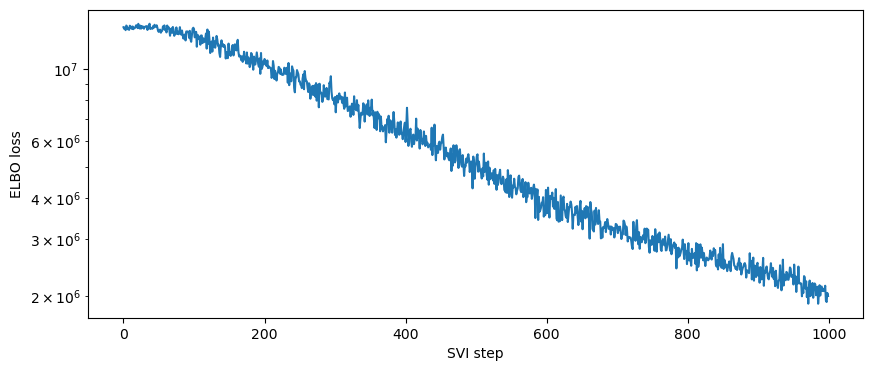

In [25]:
fig, ax = plot_losses(losses)

## post inference portion (same as raklette_daniel.py)

In [28]:
neut_sfs_full = neutral_sfs

ref_mu_ii = -1
beta_neut_full = multinomial_trans_torch(neut_sfs_full) #neut_sfs_full is the neutral sfs
pdist = "t"
trans = "abs"
post_samps=10000

# grab gene-DFE prior parameter point estimates
beta_neut = beta_neut_full[ref_mu_ii,:]
if pdist=="t":
    beta_prior_df = pyro.param("beta_prior_df")
    beta_prior_mean = pyro.param("beta_prior_mean")
    beta_prior_L = pyro.param("beta_prior_L")
    mix_probs = pyro.param("mix_probs")
elif pdist=="normal":
    mix_probs = pyro.param("mix_probs")
    beta_prior_loc = pyro.param("beta_prior_loc")
    beta_prior_scale = pyro.param("beta_prior_scale")

beta_prior_b = pyro.param("beta_prior_b")

# Sample betas from the DFE prior, representing the fit distribution across genes
if pdist=="t":
    prior_dist = dist.MixtureSameFamily(dist.Categorical(mix_probs),
                                          dist.MultivariateStudentT(df=torch.cat((beta_prior_df, torch.tensor([1000], dtype=float))), 
                                                                loc=torch.cat((beta_prior_mean, 
                                                                                   torch.tensor([0]*n_bins, dtype=float).expand((1, n_bins)))), 
                                                                scale_tril=torch.cat((beta_prior_L, 
                                                                            torch.linalg.cholesky(torch.diag(1e-8*torch.ones(n_bins, dtype=float))).expand(1, n_bins, n_bins))))
                                                             )
elif pdist=="normal":
    prior_dist = dist.MixtureSameFamily(dist.Categorical(mix_probs),
                                        dist.Normal(beta_prior_loc, beta_prior_scale).to_event(1))
prior_samps = prior_dist.sample((post_samps,))

if trans == "abs":
    prior_trans = torch.cumsum(torch.abs(prior_samps), axis=-1)
elif trans=="logabs":
    prior_trans = torch.cumsum(torch.log(torch.abs(prior_samps)+1), axis=-1)
elif trans=="relu":
    prior_trans = torch.cumsum(relu(prior_samps), axis=-1)
elif trans=="logrelu":
    prior_trans = torch.cumsum(torch.log(relu(prior_samps)+1), axis=-1)

## Prior SFS probabilities for gene effects in the absence of covariates
prior_probs = softmax(pad(beta_neut - prior_trans -
                          mu_ref[ref_mu_ii]*torch.cumsum(beta_prior_b, -1)*prior_trans
                         )
                     ).detach().numpy()

# take samples from the posterior distribution on all betas
with pyro.plate("samples", post_samps, dim=-2):
    post_samples = guide()

if pdist=="t":
    result = {"neut_sfs_full":neut_sfs_full, "beta_neut_full":beta_neut_full, "ref_mu_ii":ref_mu_ii,
              "beta_prior_df":beta_prior_df, "beta_prior_mean":beta_prior_mean, "beta_prior_L":beta_prior_L,
              "mix_probs":mix_probs, 
              "beta_prior_b":beta_prior_b, "trans":trans,
              "prior_probs":prior_probs, "post_samples":post_samples, "mu_ref":mu_ref}
elif pdist=="normal":
    result = {"neut_sfs_full":neut_sfs_full, "beta_neut_full":beta_neut_full, "ref_mu_ii":ref_mu_ii,
              "beta_prior_scale":beta_prior_scale, "beta_prior_loc":beta_prior_loc,
              "mix_probs":mix_probs,
              "beta_prior_b":beta_prior_b, "trans":trans,
              "prior_probs":prior_probs, "post_samples":post_samples, "mu_ref":mu_ref}

# calculate the posterior distribution on KL for each gene
result = calc_KL_genewise(result)

## Then calculate the posteriors for covariate betas
if n_covs > 0:
    result["post_beta_cov"] = torch.cumsum(post_samples['beta_cov'], -1)
result["losses"] = losses
result["fig"] = (fig, ax)

In [29]:
np.mean(result["KL_fw_post"], axis = 0)

array([7.76460804, 0.37161576, 7.52047177])

In [30]:
np.mean(result["KL_rv_post"], axis = 0)

array([3.98525769, 0.52109279, 3.9743914 ])